# Predicting Player Transfer Value

**By:** Inesh Jacob, Vedangi Patel, Nate Piplias, and Rodrigo Tiscareno

**Note:** The cells are designed and implemented to be run in-sequence. There may be dependencies on previously-run cells. This applies for cells subsequent to the reading of the 'player_dataset.csv'

## Table of Contents
* [Introduction](#introduction)
* [Data Extraction](#data-extraction)
* [Data Transformations](#data-transformations)
* [Feature Refinement](#data-refinement)
* [Data Exploration](#data-exploration)
* [Player Play Style - Clustering Algorithm](#clustering)
* [Predicting Player Play Style by Linear Regression](#linear-regression)
* [Conclusion](#conclusion)
* [Limitations and Next Steps](#next-steps)



## Introduction <a class="anchor" id="introduction"></a>


With more than 128, 983 professional football players registered in FIFA’s system, and tight transfer budgets, teams need to be fiscally responsible when trading players. Even the largest teams, with budgets exceeding £100 million risk falling into financial difficulty if they are unable to control their spendings. With Chelsea FC, for example, having spent €2 billion on transfers in the last 5 years, of which €660 million are loans. Often, extremely high valued players do not contribute as much to the team’s success as management may have initially hoped. 

A key factor in avoiding this, is the comprehensive understanding of the transfer market values of prospective players and the features that have the largest impact on it. This market value would then serve as a starting point for further negotiations.


In this analysis, we perform player clustering to determine the playing-style of a player and multi-variable linear regression to calculate and predict a player's transfer value based on their personal information and their in-game statistics from thr 2022-2023 season.


## Data Extraction <a class="anchor" id="data-extraction"></a>

**Note**: The data extraction process can take up to 10 minutes (data web-scraping and aggregation). Please run the cells in order to produce the best results. If you'd like access to the final player dataset after the data extraction, please click here.

In [254]:
import pandas as pd
import numpy as np
import os
import requests
from bs4 import BeautifulSoup
from functools import reduce
from unidecode import unidecode
import re
from datetime import datetime
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
import sklearn.metrics as sm
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn.preprocessing import scale
import warnings
warnings.filterwarnings('ignore')
sns.set_style("darkgrid") 

# Configuration Variables

In [136]:
NATIONS = [
    'england',
    'france',
    'holland',
    'italy',
    'germany',
    'portugal',
    'spain',
]

DF_ORDER = [
    "overall",
    "fixtures",
    "gk",
    "advanced_gk",
    "shooting",
    "passing",
    "pass_types",
    "goal_and_shot_creation",
    "defensive_actions",
    "possession",
    "playing_time",
    "miscellaneous_tasks",
    "overall_regular_season",
    "home_away_regular_season",
]

STAT_LINKS = {
    "england": {
        "Arsenal": "https://fbref.com/en/squads/18bb7c10/Arsenal-Stats",
        "Manchester_City": "https://fbref.com/en/squads/b8fd03ef/Manchester-City-Stats",
        "Manchester_United": "https://fbref.com/en/squads/19538871/Manchester-United-Stats",
        "Newcastle_United": "https://fbref.com/en/squads/b2b47a98/Newcastle-United-Stats",
        "Tottenham": "https://fbref.com/en/squads/361ca564/Tottenham-Hotspur-Stats",
        "Brighton": "https://fbref.com/en/squads/d07537b9/Brighton-and-Hove-Albion-Stats",
        "Brentford": "https://fbref.com/en/squads/cd051869/Brentford-Stats",
        "Fulham": "https://fbref.com/en/squads/fd962109/Fulham-Stats",
        "Chelsea": "https://fbref.com/en/squads/cff3d9bb/Chelsea-Stats",
        "Liverpool": "https://fbref.com/en/squads/822bd0ba/Liverpool-Stats",
        "Aston_Villa": "https://fbref.com/en/squads/8602292d/Aston-Villa-Stats",
        "Crystal_Palance": "https://fbref.com/en/squads/47c64c55/Crystal-Palace-Stats",
        "Forest": "https://fbref.com/en/squads/e4a775cb/Nottingham-Forest-Stats",
        "Leicester": "https://fbref.com/en/squads/a2d435b3/Leicester-City-Stats",
        "Wolves": "https://fbref.com/en/squads/8cec06e1/Wolverhampton-Wanderers-Stats",
        "West_Ham": "https://fbref.com/en/squads/7c21e445/West-Ham-United-Stats",
        "Leeds": "https://fbref.com/en/squads/5bfb9659/Leeds-United-Stats",
        "Everton": "https://fbref.com/en/squads/d3fd31cc/Everton-Stats",
        "Bournemouth": "https://fbref.com/en/squads/4ba7cbea/Bournemouth-Stats",
        "Southampton": "https://fbref.com/en/squads/33c895d4/Southampton-Stats",
    },
    'france': {
        "Paris Saint-Germain": "https://fbref.com/en/squads/e2d8892c/Paris-Saint-Germain-Stats",
        "Marseille": "https://fbref.com/en/squads/5725cc7b/Marseille-Stats",
        "Lens": "https://fbref.com/en/squads/fd4e0f7d/Lens-Stats",
        "Monaco": "https://fbref.com/en/squads/fd6114db/Monaco-Stats",
        "Rennes": "https://fbref.com/en/squads/b3072e00/Rennes-Stats",
        "Lille": "https://fbref.com/en/squads/cb188c0c/Lille-Stats",
        "Nice": "https://fbref.com/en/squads/132ebc33/Nice-Stats",
        "Reims": "https://fbref.com/en/squads/7fdd64e0/Reims-Stats",
        "Lorient": "https://fbref.com/en/squads/d2c87802/Lorient-Stats",
        "Lyon": "https://fbref.com/en/squads/d53c0b06/Lyon-Stats",
        "Toulouse": "https://fbref.com/en/squads/3f8c4b5f/Toulouse-Stats",
        "Clermont-Foot": "https://fbref.com/en/squads/d9676424/Clermont-Foot-Stats",
        "Montpellier": "https://fbref.com/en/squads/281b0e73/Montpellier-Stats",
        "Nantes": "https://fbref.com/en/squads/d7a486cd/Nantes-Stats",
        "Strasbourg": "https://fbref.com/en/squads/c0d3eab4/Strasbourg-Stats",
        "Brest": "https://fbref.com/en/squads/fb08dbb3/Brest-Stats",
        "Auxerre": "https://fbref.com/en/squads/5ae09109/Auxerre-Stats",
        "Ajaccio": "https://fbref.com/en/squads/7a54bb4f/Ajaccio-Stats",
        "Troyes": "https://fbref.com/en/squads/54195385/Troyes-Stats",
        "Angers": "https://fbref.com/en/squads/69236f98/Angers-Stats",
    }, 
    'spain': {
        "Barcelona": "https://fbref.com/en/squads/206d90db/Barcelona-Stats",
        "Real_Madrid": "https://fbref.com/en/squads/53a2f082/Real-Madrid-Stats",
        "Atletico_Madrid": "https://fbref.com/en/squads/db3b9613/Atletico-Madrid-Stats",
        "Real_Sociedad": "https://fbref.com/en/squads/e31d1cd9/Real-Sociedad-Stats",
        "Betis": "https://fbref.com/en/squads/fc536746/Real-Betis-Stats",
        "Villarreal": "https://fbref.com/en/squads/2a8183b3/Villarreal-Stats",
        "Athletic_Club": "https://fbref.com/en/squads/2b390eca/Athletic-Club-Stats",
        "Rayo_Vallecano": "https://fbref.com/en/squads/98e8af82/Rayo-Vallecano-Stats",
        "Osasuna": "https://fbref.com/en/squads/03c57e2b/Osasuna-Stats",
        "Mallorca": "https://fbref.com/en/squads/2aa12281/Mallorca-Stats",
        "Celta_Vigo": "https://fbref.com/en/squads/f25da7fb/Celta-Vigo-Stats",
        "Girona": "https://fbref.com/en/squads/9024a00a/Girona-Stats",
        "Sevilla": "https://fbref.com/en/squads/ad2be733/Sevilla-Stats",
        "Valladolid": "https://fbref.com/en/squads/17859612/Valladolid-Stats",
        "Espanyol": "https://fbref.com/en/squads/a8661628/Espanyol-Stats",
        "Cadiz": "https://fbref.com/en/squads/ee7c297c/Cadiz-Stats",
        "Valencia": "https://fbref.com/en/squads/dcc91a7b/Valencia-Stats",
        "Getafe": "https://fbref.com/en/squads/7848bd64/Getafe-Stats",
        "Almeria": "https://fbref.com/en/squads/78ecf4bb/Almeria-Stats",
        "Elche": "https://fbref.com/en/squads/6c8b07df/Elche-Stats",
    },
    'germany': {
        "Bayern_Munich": "https://fbref.com/en/squads/054efa67/Bayern-Munich-Stats",
        "Dortmund": "https://fbref.com/en/squads/add600ae/Dortmund-Stats",
        "RB_Leipzig": "https://fbref.com/en/squads/acbb6a5b/RB-Leipzig-Stats",
        "Union_Berlin": "https://fbref.com/en/squads/7a41008f/Union-Berlin-Stats",
        "Freiburg": "https://fbref.com/en/squads/a486e511/Freiburg-Stats",
        "Eintracht_Frankfurt": "https://fbref.com/en/squads/f0ac8ee6/Eintracht-Frankfurt-Stats",
        "Mainz_05": "https://fbref.com/en/squads/a224b06a/Mainz-05-Stats",
        "Wolfsburg": "https://fbref.com/en/squads/4eaa11d7/Wolfsburg-Stats",
        "Bayer_Leverkusen": "https://fbref.com/en/squads/c7a9f859/Bayer-Leverkusen-Stats",
        "Monchengladbach": "https://fbref.com/en/squads/32f3ee20/Monchengladbach-Stats",
        "Werder_Bremen": "https://fbref.com/en/squads/62add3bf/Werder-Bremen-Stats",
        "Koln": "https://fbref.com/en/squads/bc357bf7/Koln-Stats",
        "Augsburg": "https://fbref.com/en/squads/0cdc4311/Augsburg-Stats",
        "Bochum": "https://fbref.com/en/squads/b42c6323/Bochum-Stats",
        "Hertha_BSC": "https://fbref.com/en/squads/2818f8bc/Hertha-BSC-Stats",
        "Stuttgart": "https://fbref.com/en/squads/598bc722/Stuttgart-Stats",
        "Schalke_04": "https://fbref.com/en/squads/c539e393/Schalke-04-Stats",
        "Hoffenheim": "https://fbref.com/en/squads/033ea6b8/Hoffenheim-Stats",
    },
    'italy': {
        "Napoli": "https://fbref.com/en/squads/d48ad4ff/Napoli-Stats",
        "Internazionale": "https://fbref.com/en/squads/d609edc0/Internazionale-Stats",
        "Lazio": "https://fbref.com/en/squads/7213da33/Lazio-Stats",
        "Milan": "https://fbref.com/en/squads/dc56fe14/Milan-Stats",
        "Roma": "https://fbref.com/en/squads/cf74a709/Roma-Stats",
        "Atalanta": "https://fbref.com/en/squads/922493f3/Atalanta-Stats",
        "Juventus": "https://fbref.com/en/squads/e0652b02/Juventus-Stats",
        "Torino": "https://fbref.com/en/squads/105360fe/Torino-Stats",
        "Bologna": "https://fbref.com/en/squads/1d8099f8/Bologna-Stats",
        "Sassuolo": "https://fbref.com/en/squads/e2befd26/Sassuolo-Stats",
        "Udinese": "https://fbref.com/en/squads/04eea015/Udinese-Stats",
        "Fiorentina": "https://fbref.com/en/squads/421387cf/Fiorentina-Stats",
        "Monza": "https://fbref.com/en/squads/21680aa4/Monza-Stats",
        "Empoli": "https://fbref.com/en/squads/a3d88bd8/Empoli-Stats",
        "Lecce": "https://fbref.com/en/squads/ffcbe334/Lecce-Stats",
        "Salernitana": "https://fbref.com/en/squads/c5577084/Salernitana-Stats",
        "Spezia": "https://fbref.com/en/squads/68449f6d/Spezia-Stats",
        "Hellas-Verona": "https://fbref.com/en/squads/0e72edf2/Hellas-Verona-Stats",
        "Cremonese": "https://fbref.com/en/squads/9aad3a77/Cremonese-Stats",
        "Sampdoria": "https://fbref.com/en/squads/8ff9e3b3/Sampdoria-Stats",
    },
    'portugal': {
        "Benfica": "https://fbref.com/en/squads/a77c513e/Benfica-Stats",
        "Porto": "https://fbref.com/en/squads/5e876ee6/Porto-Stats",
        "Braga": "https://fbref.com/en/squads/69d84c29/Braga-Stats",
        "Sporting": "https://fbref.com/en/squads/13dc44fd/Sporting-CP-Stats",
        "Vitoria": "https://fbref.com/en/squads/3f319bc9/Vitoria-Guimaraes-Stats",
        "Arouca": "https://fbref.com/en/squads/0d36ddd4/Arouca-Stats",
        "Casa": "https://fbref.com/en/squads/b20a2b76/Casa-Pia-Stats",
        "Rio": "https://fbref.com/en/squads/eea856da/Rio-Ave-Stats",
        "Famalicao": "https://fbref.com/en/squads/2de656d5/Famalicao-Stats",
        "Boavista": "https://fbref.com/en/squads/37b7e9e2/Boavista-Stats",
        "Chaves": "https://fbref.com/en/squads/bf4e8a13/Chaves-Stats",
        "Vizela": "https://fbref.com/en/squads/b9daacef/Vizela-Stats",
        "Vincente": "https://fbref.com/en/squads/6a329209/Gil-Vicente-FC-Stats",
        "Portimonense": "https://fbref.com/en/squads/a549d6c6/Portimonense-Stats",
        "Estoril": "https://fbref.com/en/squads/00c41b75/Estoril-Stats",
        "Maritimo": "https://fbref.com/en/squads/c1b0f61b/Maritimo-Stats",
        "Pacos": "https://fbref.com/en/squads/f6af6f6f/Pacos-de-Ferreira-Stats",
        "Santa-Clara": "https://fbref.com/en/squads/f5b64cb1/Santa-Clara-Stats",
    },
    'holland': {
        "Feyenoord": "https://fbref.com/en/squads/fb4ca611/Feyenoord-Stats",
        "Ajax": "https://fbref.com/en/squads/19c3f8c4/Ajax-Stats",
        "Alkmaar": "https://fbref.com/en/squads/3986b791/AZ-Alkmaar-Stats",
        "PSV": "https://fbref.com/en/squads/e334d850/PSV-Eindhoven-Stats",
        "Rotterdam": "https://fbref.com/en/squads/146a68ce/Sparta-Rotterdam-Stats",
        "Twente": "https://fbref.com/en/squads/a1f721d3/Twente-Stats",
        "Utrecht": "https://fbref.com/en/squads/2a428619/Utrecht-Stats",
        "Nijmegen": "https://fbref.com/en/squads/fc629994/NEC-Nijmegen-Stats",
        "Waalwijk": "https://fbref.com/en/squads/bb14adb3/RKC-Waalwijk-Stats",
        "Heerenveen": "https://fbref.com/en/squads/193ff7aa/Heerenveen-Stats",
        "Go-Ahead-Eagles": "https://fbref.com/en/squads/e33d6108/Go-Ahead-Eagles-Stats",
        "Fortuna-Sittard": "https://fbref.com/en/squads/bd08295c/Fortuna-Sittard-Stats",
        "Volendam": "https://fbref.com/en/squads/8783f4ee/Volendam-Stats",
        "Vitesse": "https://fbref.com/en/squads/209d7fa2/Vitesse-Stats",
        "Emmen": "https://fbref.com/en/squads/01888db1/Emmen-Stats",
        "Excelsior": "https://fbref.com/en/squads/740cb7d4/Excelsior-Stats",
        "Groningen": "https://fbref.com/en/squads/bec05adb/Groningen-Stats",
        "Cambuur": "https://fbref.com/en/squads/5c9e307a/Cambuur-Stats",
    }, 
}

INFO_LINKS = {
    'england': [
        "https://www.transfermarkt.us/manchester-city/kader/verein/281/saison_id/2022/plus/1",
        "https://www.transfermarkt.us/chelsea-fc/kader/verein/631/saison_id/2022/plus/1",
        "https://www.transfermarkt.us/arsenal-fc/kader/verein/11/saison_id/2022/plus/1",
        "https://www.transfermarkt.us/liverpool-fc/kader/verein/31/saison_id/2022/plus/1",
        "https://www.transfermarkt.us/manchester-united/kader/verein/985/saison_id/2022/plus/1",
        "https://www.transfermarkt.us/tottenham-hotspur/kader/verein/148/saison_id/2022/plus/1",
        "https://www.transfermarkt.us/newcastle-united/kader/verein/762/saison_id/2022/plus/1",
        "https://www.transfermarkt.us/west-ham-united/kader/verein/379/saison_id/2022/plus/1",
        "https://www.transfermarkt.us/leicester-city/kader/verein/1003/saison_id/2022/plus/1",
        "https://www.transfermarkt.us/aston-villa/kader/verein/405/saison_id/2022/plus/1",
        "https://www.transfermarkt.us/wolverhampton-wanderers/kader/verein/543/saison_id/2022/plus/1",
        "https://www.transfermarkt.us/fc-southampton/kader/verein/180/saison_id/2022/plus/1",
        "https://www.transfermarkt.us/brighton-amp-hove-albion/kader/verein/1237/saison_id/2022/plus/1",
        "https://www.transfermarkt.us/fc-everton/kader/verein/29/saison_id/2022/plus/1",
        "https://www.transfermarkt.us/nottingham-forest/kader/verein/703/saison_id/2022/plus/1",
        "https://www.transfermarkt.us/brentford-fc/kader/verein/1148/saison_id/2022/plus/1",
        "https://www.transfermarkt.us/leeds-united/kader/verein/399/saison_id/2022/plus/1",
        "https://www.transfermarkt.us/crystal-palace/kader/verein/873/saison_id/2022/plus/1",
        "https://www.transfermarkt.us/fulham-fc/kader/verein/931/saison_id/2022/plus/1",
        "https://www.transfermarkt.us/afc-bournemouth/kader/verein/989/saison_id/2022/plus/1",
    ],
    'spain': [
        "https://www.transfermarkt.us/real-madrid/kader/verein/418/saison_id/2022/plus/1",
        "https://www.transfermarkt.us/fc-barcelona/kader/verein/131/saison_id/2022/plus/1",
        "https://www.transfermarkt.us/atletico-de-madrid/kader/verein/13/saison_id/2022/plus/1",
        "https://www.transfermarkt.us/real-sociedad/kader/verein/681/saison_id/2022/plus/1",
        "https://www.transfermarkt.us/villarreal-cf/kader/verein/1050/saison_id/2022/plus/1",
        "https://www.transfermarkt.us/real-betis-balompie/kader/verein/150/saison_id/2022/plus/1",
        "https://www.transfermarkt.us/valencia-cf/kader/verein/1049/saison_id/2022/plus/1",
        "https://www.transfermarkt.us/sevilla-fc/kader/verein/368/saison_id/2022/plus/1",
        "https://www.transfermarkt.us/athletic-bilbao/kader/verein/621/saison_id/2022/plus/1",
        "https://www.transfermarkt.us/getafe-cf/kader/verein/3709/saison_id/2022/plus/1",
        "https://www.transfermarkt.us/celta-de-vigo/kader/verein/940/saison_id/2022/plus/1",
        "https://www.transfermarkt.us/ca-osasuna/kader/verein/331/saison_id/2022/plus/1",
        "https://www.transfermarkt.us/girona-fc/kader/verein/12321/saison_id/2022/plus/1",
        "https://www.transfermarkt.us/rcd-espanyol-barcelona/kader/verein/714/saison_id/2022/plus/1",
        "https://www.transfermarkt.us/ud-almeria/kader/verein/3302/saison_id/2022/plus/1",
        "https://www.transfermarkt.us/rayo-vallecano/kader/verein/367/saison_id/2022/plus/1",
        "https://www.transfermarkt.us/rcd-mallorca/kader/verein/237/saison_id/2022/plus/1",
        "https://www.transfermarkt.us/elche-cf/kader/verein/1531/saison_id/2022/plus/1",
        "https://www.transfermarkt.us/real-valladolid-cf/kader/verein/366/saison_id/2022/plus/1",
        "https://www.transfermarkt.us/cadiz-cf/kader/verein/2687/saison_id/2022/plus/1",
    ],
    'germany': [
        "https://www.transfermarkt.com/bayern-munich/kader/verein/27/saison_id/2022/plus/1",
        "https://www.transfermarkt.com/borussia-dortmund/kader/verein/16/saison_id/2022/plus/1",
        "https://www.transfermarkt.com/rb-leipzig/kader/verein/23826/saison_id/2022/plus/1",
        "https://www.transfermarkt.com/bayer-04-leverkusen/kader/verein/15/saison_id/2022/plus/1",
        "https://www.transfermarkt.com/eintracht-frankfurt/kader/verein/24/saison_id/2022/plus/1",
        "https://www.transfermarkt.com/borussia-monchengladbach/kader/verein/18/saison_id/2022/plus/1",
        "https://www.transfermarkt.com/vfl-wolfsburg/kader/verein/82/saison_id/2022/plus/1",
        "https://www.transfermarkt.com/tsg-1899-hoffenheim/kader/verein/533/saison_id/2022/plus/1",
        "https://www.transfermarkt.com/sc-freiburg/kader/verein/60/saison_id/2022/plus/1",
        "https://www.transfermarkt.com/vfb-stuttgart/kader/verein/79/saison_id/2022/plus/1",
        "https://www.transfermarkt.com/1-fc-union-berlin/kader/verein/89/saison_id/2022/plus/1",
        "https://www.transfermarkt.com/1-fsv-mainz-05/kader/verein/39/saison_id/2022/plus/1",
        "https://www.transfermarkt.com/fc-augsburg/kader/verein/167/saison_id/2022/plus/1",
        "https://www.transfermarkt.com/hertha-bsc/kader/verein/44/saison_id/2022/plus/1",
        "https://www.transfermarkt.com/1-fc-koln/kader/verein/3/saison_id/2022/plus/1",
        "https://www.transfermarkt.com/sv-werder-bremen/kader/verein/86/saison_id/2022/plus/1",
        "https://www.transfermarkt.com/fc-schalke-04/kader/verein/33/saison_id/2022/plus/1",
        "https://www.transfermarkt.com/vfl-bochum/kader/verein/80/saison_id/2022/plus/1",
    ],
    'france': [
        "https://www.transfermarkt.us/paris-saint-germain/kader/verein/583/saison_id/2022/plus/1",
        "https://www.transfermarkt.us/stade-rennais-fc/kader/verein/273/saison_id/2022/plus/1",
        "https://www.transfermarkt.us/as-monaco/kader/verein/162/saison_id/2022/plus/1",
        "https://www.transfermarkt.us/olympique-marseille/kader/verein/244/saison_id/2022/plus/1",
        "https://www.transfermarkt.us/ogc-nice/kader/verein/417/saison_id/2022/plus/1",
        "https://www.transfermarkt.us/olympique-lyon/kader/verein/1041/saison_id/2022/plus/1",
        "https://www.transfermarkt.us/losc-lille/kader/verein/1082/saison_id/2022/plus/1",
        "https://www.transfermarkt.us/rc-lens/kader/verein/826/saison_id/2022/plus/1",
        "https://www.transfermarkt.us/fc-nantes/kader/verein/995/saison_id/2022/plus/1",
        "https://www.transfermarkt.us/montpellier-hsc/kader/verein/969/saison_id/2022/plus/1",
        "https://www.transfermarkt.us/rc-strasbourg-alsace/kader/verein/667/saison_id/2022/plus/1",
        "https://www.transfermarkt.us/fc-lorient/kader/verein/1158/saison_id/2022/plus/1",
        "https://www.transfermarkt.us/estac-troyes/kader/verein/1095/saison_id/2022/plus/1",
        "https://www.transfermarkt.us/stade-brestois-29/kader/verein/3911/saison_id/2022/plus/1",
        "https://www.transfermarkt.us/stade-reims/kader/verein/1421/saison_id/2022/plus/1",
        "https://www.transfermarkt.us/fc-toulouse/kader/verein/415/saison_id/2022/plus/1",
        "https://www.transfermarkt.us/angers-sco/kader/verein/1420/saison_id/2022/plus/1",
        "https://www.transfermarkt.us/aj-auxerre/kader/verein/290/saison_id/2022/plus/1",
        "https://www.transfermarkt.us/clermont-foot-63/kader/verein/3524/saison_id/2022/plus/1",
        "https://www.transfermarkt.us/ac-ajaccio/kader/verein/1147/saison_id/2022/plus/1",
    ],
    'italy': [
        "https://www.transfermarkt.us/ac-milan/kader/verein/5/saison_id/2022/plus/1",
        "https://www.transfermarkt.us/inter-milan/kader/verein/46/saison_id/2022/plus/1",
        "https://www.transfermarkt.us/ssc-napoli/kader/verein/6195/saison_id/2022/plus/1",
        "https://www.transfermarkt.us/juventus-fc/kader/verein/506/saison_id/2022/plus/1",
        "https://www.transfermarkt.us/as-roma/kader/verein/12/saison_id/2022/plus/1",
        "https://www.transfermarkt.us/atalanta-bc/kader/verein/800/saison_id/2022/plus/1",
        "https://www.transfermarkt.us/ss-lazio/kader/verein/398/saison_id/2022/plus/1",
        "https://www.transfermarkt.us/acf-fiorentina/kader/verein/430/saison_id/2022/plus/1",
        "https://www.transfermarkt.us/us-sassuolo/kader/verein/6574/saison_id/2022/plus/1",
        "https://www.transfermarkt.us/torino-fc/kader/verein/416/saison_id/2022/plus/1",
        "https://www.transfermarkt.us/udinese-calcio/kader/verein/410/saison_id/2022/plus/1",
        "https://www.transfermarkt.us/bologna-fc-1909/kader/verein/1025/saison_id/2022/plus/1",
        "https://www.transfermarkt.us/ac-monza/kader/verein/2919/saison_id/2022/plus/1",
        "https://www.transfermarkt.us/us-salernitana-1919/kader/verein/380/saison_id/2022/plus/1",
        "https://www.transfermarkt.us/fc-empoli/kader/verein/749/saison_id/2022/plus/1",
        "https://www.transfermarkt.us/spezia-calcio/kader/verein/3522/saison_id/2022/plus/1",
        "https://www.transfermarkt.us/hellas-verona/kader/verein/276/saison_id/2022/plus/1",
        "https://www.transfermarkt.us/us-lecce/kader/verein/1005/saison_id/2022/plus/1",
        "https://www.transfermarkt.us/uc-sampdoria/kader/verein/1038/saison_id/2022/plus/1",
        "https://www.transfermarkt.us/us-cremonese/kader/verein/2239/saison_id/2022/plus/1",
    ],
    'portugal': [
        "https://www.transfermarkt.us/sl-benfica/kader/verein/294/saison_id/2022/plus/1",
        "https://www.transfermarkt.us/fc-porto/kader/verein/720/saison_id/2022/plus/1",
        "https://www.transfermarkt.us/sporting-cp/kader/verein/336/saison_id/2022/plus/1",
        "https://www.transfermarkt.us/sc-braga/kader/verein/1075/saison_id/2022/plus/1",
        "https://www.transfermarkt.us/vitoria-guimaraes-sc/kader/verein/2420/saison_id/2022/plus/1",
        "https://www.transfermarkt.us/fc-famalicao/kader/verein/3329/saison_id/2022/plus/1",
        "https://www.transfermarkt.us/gil-vicente-fc/kader/verein/2424/saison_id/2022/plus/1",
        "https://www.transfermarkt.us/cd-santa-clara/kader/verein/2423/saison_id/2022/plus/1",
        "https://www.transfermarkt.us/gd-estoril-praia/kader/verein/1465/saison_id/2022/plus/1",
        "https://www.transfermarkt.us/portimonense-sc/kader/verein/7378/saison_id/2022/plus/1",
        "https://www.transfermarkt.us/boavista-fc/kader/verein/2503/saison_id/2022/plus/1",
        "https://www.transfermarkt.us/cs-maritimo/kader/verein/1301/saison_id/2022/plus/1",
        "https://www.transfermarkt.us/casa-pia-ac/kader/verein/3268/saison_id/2022/plus/1",
        "https://www.transfermarkt.us/fc-pacos-de-ferreira/kader/verein/2995/saison_id/2022/plus/1",
        "https://www.transfermarkt.us/fc-arouca/kader/verein/8024/saison_id/2022/plus/1",
        "https://www.transfermarkt.us/fc-vizela/kader/verein/6912/saison_id/2022/plus/1",
        "https://www.transfermarkt.us/rio-ave-fc/kader/verein/2425/saison_id/2022/plus/1",
        "https://www.transfermarkt.us/gd-chaves/kader/verein/3325/saison_id/2022/plus/1",
    ],
    'holland': [
        "https://www.transfermarkt.us/ajax-amsterdam/kader/verein/610/saison_id/2022/plus/1",
        "https://www.transfermarkt.us/psv-eindhoven/kader/verein/383/saison_id/2022/plus/1",
        "https://www.transfermarkt.us/feyenoord-rotterdam/kader/verein/234/saison_id/2022/plus/1",
        "https://www.transfermarkt.us/az-alkmaar/kader/verein/1090/saison_id/2022/plus/1",
        "https://www.transfermarkt.us/fc-utrecht/kader/verein/200/saison_id/2022/plus/1",
        "https://www.transfermarkt.us/twente-enschede-fc/kader/verein/317/saison_id/2022/plus/1",
        "https://www.transfermarkt.us/vitesse-arnhem/kader/verein/499/saison_id/2022/plus/1",
        "https://www.transfermarkt.us/sc-heerenveen/kader/verein/306/saison_id/2022/plus/1",
        "https://www.transfermarkt.us/fc-groningen/kader/verein/202/saison_id/2022/plus/1",
        "https://www.transfermarkt.us/fortuna-sittard/kader/verein/385/saison_id/2022/plus/1",
        "https://www.transfermarkt.us/nec-nijmegen/kader/verein/467/saison_id/2022/plus/1",
        "https://www.transfermarkt.us/sparta-rotterdam/kader/verein/468/saison_id/2022/plus/1",
        "https://www.transfermarkt.us/sc-cambuur-leeuwarden/kader/verein/133/saison_id/2022/plus/1",
        "https://www.transfermarkt.us/excelsior-rotterdam/kader/verein/798/saison_id/2022/plus/1",
        "https://www.transfermarkt.us/fc-volendam/kader/verein/724/saison_id/2022/plus/1",
        "https://www.transfermarkt.us/fc-emmen/kader/verein/1283/saison_id/2022/plus/1",
        "https://www.transfermarkt.us/rkc-waalwijk/kader/verein/235/saison_id/2022/plus/1",
        "https://www.transfermarkt.us/go-ahead-eagles/kader/verein/1435/saison_id/2022/plus/1",
    ],
}

In [586]:
# Scrapes the player statistics from FBREF links in the configuration profile.
def get_player_statistics(stat_links, df_order):
    for nations in STAT_LINKS:
        for team in STAT_LINKS[nations]:
            df_list = pd.read_html(STAT_LINKS[nations][team], header=1)
            for i, df in enumerate(df_list):
                if not os.path.isdir(f"{nations}/player_stats/{team}/"):
                    os.makedirs(f"{nations}/player_stats/{team}/")
                df.to_csv(f"{nations}/player_stats/{team}/{df_order[i]}.csv", index=False)

In [4]:
get_player_statistics(STAT_LINKS, DF_ORDER)

In [587]:
# Scrapes the player information data from the TransferMarkt links in the configuration profile.
def get_player_info(INFO_LINKS):
    
    for nation in INFO_LINKS:
        for team in INFO_LINKS[nation]:

        # Get team name.
            team_name = team.split("/")[3]

            headers = {'User-Agent': 'Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/47.0.2526.106 Safari/537.36'}
            page = team
            pageTree = requests.get(page, headers=headers)
            pageSoup = BeautifulSoup(pageTree.content, 'html.parser')

            # Acquire player names, prices and positions. 
            names = []
            positions = []
            tables= pageSoup.find_all('table', class_='inline-table')
            for table in tables:
                rows = table.find_all('tr')
                name = rows[0].text.strip()
                position = rows[1].text.strip()
                names.append(name)
                positions.append(position)

            player_prices = pageSoup.find_all(class_='rechts hauptlink')
            prices = []
            for price in player_prices:
                price = price.text.strip()
                prices.append(price)

            # Store in info dataframe.
            info = pd.DataFrame({'name': names, 'price': prices, 'position':positions})

            # Custom logic to acquire dob, nationality, height, foot, join_date, and contract_expiration.
            data_rows = []
            tables= pageSoup.find_all('table', class_='items')
            for table in tables:
                rows = table.find_all('td', {"class": "zentriert"})
                for i in range(len(rows)):
                    data_rows.append(rows[i])


            general = [data_rows[i:i + 8] for i in range(0, len(data_rows), 8)]
            overall = []
            for g in general:
                overall.append(dict(
                  dob = g[1].text.strip(),
                  nationality = g[2].img['alt'],
                  height = g[3].text.strip(),
                  foot = g[4].text.strip(),
                  join_date = g[5].text.strip(),
                  contract_expiration = g[7].text.strip(), 
              )
              )
            # Create info2 dataframe with additional information.
            info2 = pd.DataFrame(overall)

            # Concat info with info2 to combine information.
            overall = pd.concat([info, info2], axis=1)

            if not os.path.isdir(f"{nation}/player_info"):
                  os.makedirs(f"{nation}/player_info")

            # Export dataframe to nation directory.
            overall.to_csv(f"{nation}/player_info/{team_name}.csv", index=False)

In [6]:
get_player_info(INFO_LINKS)

#### Clelan-Up Functions

The following functions serve to clean-up and remove redundant records the incoming data from the player statistics data from the FBREF websbite.

In [9]:
def clean_up_defensive_actions(df):
    df = df.iloc[:-2]
    
    df.drop(columns=[
        '90s',
        'Matches',
        'Nation',
        'Pos',
        'Age',
        'Tkl.1',
        'Att',
        'Tkl%',
        'Lost',
        'Blocks',
        'Tkl+Int',
        'Pass'
    ], inplace=True)
    
    df.rename(columns={
        'Tkl': 'tackles',
        'TklW': 'tackles_won',
        'Def 3rd': 'defensive_third_tackles',
        'Mid 3rd': 'midfield_tackles',
        'Att 3rd': 'attacking_third_tackles',
        'Sh': 'shots_blocked',
        'Pass': 'passes_blocked',
        'Int': 'interceptions',
        'Clr': 'clearances',
        'Err': 'errors_leading_to_goal'
    }, inplace=True)
    
    return df

In [10]:
def clean_up_goal_and_shot(df):
    df = df.iloc[:-2]
    
    df.drop(columns=[
        '90s',
        'Matches',
        'Nation',
        'Pos',
        'Age',
        'SCA90',
        'GCA90',
    ], inplace=True)
    
    df.rename(columns={
        'SCA': 'shot_creating_actions',
        'PassLive': 'sca_live_passes',
        'PassDead': 'sca_dead_passes',
        'TO': 'sca_take_ons',
        'Sh': 'sca_shots',
        'Fld': 'sca_fouls_drawn',
        'Def': 'sca_defensive_actions',
        'GCA': 'goal_creation_actions',
        'PassLive.1': 'gca_live_passes',
        'PassDead.1': 'gca_dead_passes',
        'TO.1': 'gca_take_ons',
        'Sh.1': 'gca_shots',
        'Fld.1': 'gca_fouls_drawn',
        'Def.1': 'gca_defensive_actions',
    }, inplace=True)
    
    return df

In [11]:
def clean_up_miscellaneous(df):
    df = df.iloc[:-2]
    
    df.drop(columns=[
        '90s',
        'Matches',
        'Nation',
        'Pos',
        'Age',
        '2CrdY',
        'Crs',
        'Int',
        'TklW',
        'Won%',
    ], inplace=True)
    
    df.rename(columns={
        'CrdY': 'yellow_cards',
        'CrdR': 'red_cards',
        'Fls': 'fouls',
        'Fld': 'fouls_drawn',
        'Off': 'offsides',
        'Fls': 'fouls',
        'Fld': 'fouls_drawn',
        'Off': 'offsides',
        'PKwon': 'penalties_won',
        'PKcon': 'penalties_conceded',
        'OG': 'own_goals',
        'Recov': 'ball_recoveries',
        'Won': 'aerial_duels_won',
        'Lost': 'aerial_duels_lost',
    }, inplace=True)
    
    return df

In [12]:
def clean_up_passing(df):
    df = df.iloc[:-2]
    
    df.rename(columns={
        'Cmp.1': 'short_passes_completed',
        'Att.1': 'short_passes_attempted',
        'Cmp.2': 'medium_passes_completed',
        'Att.2': 'medium_passes_attempted',
        'Cmp.3': 'long_passes_completed',
        'Att.3': 'long_passes_attempted',
        'Ast': 'assists',
        'xA': 'expected_assists',
        'KP': 'key_passes',
        '1/3': 'passes_into_final_third',
        'PPA': 'passes_into_penalty_box',
        'CrsPA': 'crosses_into_penalty_area',
        'PrgP': 'progressive_passes',
    }, inplace=True)
   
    df.drop(columns=[
        '90s',
        'Matches',
        'Nation',
        'Pos',
        'Age',
        'Cmp',
        'Att',
        'Cmp%',
        'TotDist',
        'PrgDist',
        'Cmp%.1',
        'Cmp%.2',
        'Cmp%.3',
        'xAG',
        'A-xAG',
    ], inplace=True)
    
    return df

In [13]:
def clean_up_playing_time(df):
    df = df.iloc[:-2]
    
    df = df[['Player', 'Min', 'MP', 'Starts']]
    
    df.rename(columns={
        'Min': 'minutes_played',
        'MP': 'matches_played',
        'Starts': 'matches_started',
    }, inplace=True)
    
    return df

In [14]:
def clean_up_possession(df):
    df = df.iloc[:-2]
    
    df.drop(columns=[
        '90s',
        'Matches',
        'Nation',
        'Pos',
        'Age',
        'Touches',
        'Live',
        'Succ%',
        'Tkld%',
        'Rec',
        'PrgR',
    ], inplace=True)
    
    df.rename(columns={
        'Def Pen': 'touches_penalty_area_defending',
        'Def 3rd': 'touches_defensive_third',
        'Mid 3rd': 'touches_middle_third',
        'Att 3rd': 'touches_attacking_third',
        'Att Pen': 'touches_penalty_area_attacking',
        'Att': 'attempted_take_ons',
        'Succ': 'successful_take_ons',
        'Tkld': 'tackled_take_ons',
        'Carries': 'carries',
        'TotDist': 'total_carrying_distance',
        'PrgDist': 'progressive_carrying_distance',
        'PrgC': 'progressive_carries',
        '1/3': 'carries_into_final_third',
        'CPA': 'carries_into_penalty_area',
        'Mis': 'carry_miscontrols',
        'Dis': 'carry_dispossessions',
    }, inplace=True)
    
    return df

In [15]:
def clean_up_shooting(df):
    df = df.iloc[:-2]
    
    df.drop(columns=[
        '90s',
        'Matches',
        'Nation',
        'Pos',
        'Age',
        'SoT%',
        'Sh/90',
        'SoT/90',
        'G/SoT',
        'npxG',
        'npxG/Sh',
        'G-xG',
        'np:G-xG',
    ], inplace=True)
    
    df.rename(columns={
        'Gls': 'goals',
        'Sh': 'total_shots',
        'SoT': 'shots_on_target',
        'G/Sh': 'goals_per_shot',
        'Dist': 'average_shot_distance',
        'FK': 'freekick_shots',
        'PK': 'penalty_kicks_converted',
        'PKatt': 'penalty_kicks_attempted',
    }, inplace=True)
    
    return df

#### Cleaning and Aggregating Data from Web-Scrapes

In [29]:
# Perform the general dropping and renaming of columns.
def clean_up_statistic_dataframes(directory):
    
    files = [
        ("playing_time.csv", clean_up_playing_time),
        ("defensive_actions.csv", clean_up_defensive_actions),
        ("goal_and_shot_creation.csv", clean_up_goal_and_shot),
        ("miscellaneous_tasks.csv", clean_up_miscellaneous),
        ("passing.csv", clean_up_passing),
        ("possession.csv", clean_up_possession),
        ("shooting.csv", clean_up_shooting),
    ]
    
    dfs = []
    for file, clean_func in files:
        df = pd.read_csv(f"{directory}/{file}")
        df = clean_func(df)
        dfs.append(df)
    
    df_merged = pd.concat(dfs, axis=1)
    
    return df_merged


In [26]:
# For each nation, compile the in-game statistics dataset.
def get_statistics_df(NATIONS):
    for nation in NATIONS:
        rootdir = f'{nation}/player_stats/'
        dfs = []
        for i, file in enumerate(os.listdir(rootdir)):
            d = os.path.join(rootdir, file)
            if ".ipynb_checkpoints" in d:
                continue
            dfs.append(clean_up_statistic_dataframes(d))
        result_df = pd.concat(dfs, ignore_index=True)
        result_df = result_df.loc[:, ~result_df.columns.duplicated()]

        result_df.to_csv(f"{nation}/overall_player_stats.csv", index=False)

In [ ]:
get_statistics_df(NATIONS)

In [27]:
# For each nation, compile the player information dataset.
def get_information_df(NATIONS):
    for nation in NATIONS:
        directory = f'{nation}/player_info'

        csv_files = [f for f in os.listdir(directory) if f.endswith('.csv')]

        dfs = []

        for csv_file in csv_files:
            df = pd.read_csv(os.path.join(directory, csv_file))
            dfs.append(df)

        merged_df = pd.concat(dfs, ignore_index=True)

        merged_df.to_csv(f"{nation}/player_info.csv", index=False)

In [21]:
get_information_df(NATIONS)

In [28]:
# Join the player information and player statistics tables for each nation.
def compile_nation_df(NATIONS):
    for nation in NATIONS:

        df1 = pd.read_csv(f"{nation}/player_info.csv")
        df2 = pd.read_csv(f"{nation}/overall_player_stats.csv")

        df1["normalized_named"] = df1["name"].apply(unidecode)
        df2["normalized_named"] = df2["Player"].apply(unidecode)

        merged_df = pd.merge(df1, df2, on="normalized_named", how="inner")
        merged_df.drop(columns=["normalized_named", "Player"], axis=1, inplace=True)
        
        if not os.path.isdir(f"finalized_nation_datasets"):
                  os.makedirs(f"finalized_nation_datasets")
        
        merged_df.to_csv(f"finalized_nation_datasets/{nation}_dataset.csv", index=False)

In [23]:
compile_nation_df(NATIONS)

In [30]:
# For each nation's combined dataset, compile and aggregate the data to produce the overall player_dataset.csv file.
def get_general_dataset():
    directory = f'finalized_nation_datasets/'

    csv_files = [f for f in os.listdir(directory) if f.endswith('.csv')]

    dfs = []

    for csv_file in csv_files:
        df = pd.read_csv(os.path.join(directory, csv_file))
        dfs.append(df)

    merged_df = pd.concat(dfs, ignore_index=True)

    merged_df.to_csv(f"player_dataset.csv", index=False)

In [31]:
get_general_dataset()

In [137]:
# Read the generated dataset.
df = pd.read_csv('player_dataset.csv')

## Data Transformation <a class="anchor" id="data-transformations"></a>

#### Converting Price Variable to a Numerical Variable

#### Transformation

In [138]:
# Apply transformations to convert price to numeric variable.
df['price'] = df['price'].str.replace('.', '')
df['price'] = df['price'].str.replace('€', '')
df['price'] = df['price'].str.replace('m', '0000').str.replace('k', '000')
df['price'] = df['price'].astype('double', errors='ignore')
df = df[df['price'] != '-'].reset_index(drop=True)
df['price'] = df['price'].astype('int')

#### Verification

In [139]:
df['price'].head()

0    1200000
1     500000
2     400000
3    5000000
4    3500000
Name: price, dtype: int64

#### Deleting Goalkeepers or Players With No Playing Time

#### Transformation

In [140]:
df = df[~df['minutes_played'].isna()].reset_index(drop=True)
df = df[df['position'] != 'Goalkeeper'].reset_index(drop=True)

#### Verification

In [141]:
df[df['minutes_played'].isna()]

Empty DataFrame
Columns: [name, price, position, dob, nationality, height, foot, join_date, contract_expiration, minutes_played, matches_played, matches_started, tackles, tackles_won, defensive_third_tackles, midfield_tackles, attacking_third_tackles, shots_blocked, interceptions, clearances, errors_leading_to_goal, shot_creating_actions, sca_live_passes, sca_dead_passes, sca_take_ons, sca_shots, sca_fouls_drawn, sca_defensive_actions, goal_creation_actions, gca_live_passes, gca_dead_passes, gca_take_ons, gca_shots, gca_fouls_drawn, gca_defensive_actions, yellow_cards, red_cards, fouls, fouls_drawn, offsides, penalties_won, penalties_conceded, own_goals, ball_recoveries, aerial_duels_won, aerial_duels_lost, short_passes_completed, short_passes_attempted, medium_passes_completed, medium_passes_attempted, long_passes_completed, long_passes_attempted, assists, expected_assists, key_passes, passes_into_final_third, passes_into_penalty_box, crosses_into_penalty_area, progressive_passes, touches_penalty_area_defending, touches_defensive_third, touches_middle_third, touches_attacking_third, touches_penalty_area_attacking, attempted_take_ons, successful_take_ons, tackled_take_ons, carries, total_carrying_distance, progressive_carrying_distance, progressive_carries, carries_into_final_third, carries_into_penalty_area, carry_miscontrols, carry_dispossessions, goals, total_shots, shots_on_target, goals_per_shot, average_shot_distance, freekick_shots, penalty_kicks_converted, penalty_kicks_attempted, xG]
Index: []

[0 rows x 84 columns]

In [142]:
df[df['position'] == 'Goalkeeper']

Empty DataFrame
Columns: [name, price, position, dob, nationality, height, foot, join_date, contract_expiration, minutes_played, matches_played, matches_started, tackles, tackles_won, defensive_third_tackles, midfield_tackles, attacking_third_tackles, shots_blocked, interceptions, clearances, errors_leading_to_goal, shot_creating_actions, sca_live_passes, sca_dead_passes, sca_take_ons, sca_shots, sca_fouls_drawn, sca_defensive_actions, goal_creation_actions, gca_live_passes, gca_dead_passes, gca_take_ons, gca_shots, gca_fouls_drawn, gca_defensive_actions, yellow_cards, red_cards, fouls, fouls_drawn, offsides, penalties_won, penalties_conceded, own_goals, ball_recoveries, aerial_duels_won, aerial_duels_lost, short_passes_completed, short_passes_attempted, medium_passes_completed, medium_passes_attempted, long_passes_completed, long_passes_attempted, assists, expected_assists, key_passes, passes_into_final_third, passes_into_penalty_box, crosses_into_penalty_area, progressive_passes, touches_penalty_area_defending, touches_defensive_third, touches_middle_third, touches_attacking_third, touches_penalty_area_attacking, attempted_take_ons, successful_take_ons, tackled_take_ons, carries, total_carrying_distance, progressive_carrying_distance, progressive_carries, carries_into_final_third, carries_into_penalty_area, carry_miscontrols, carry_dispossessions, goals, total_shots, shots_on_target, goals_per_shot, average_shot_distance, freekick_shots, penalty_kicks_converted, penalty_kicks_attempted, xG]
Index: []

[0 rows x 84 columns]

#### Mapping Positions to General Positions

#### Transformation

In [143]:
position_mappings = {'Centre-Back': 'Defender', 'Left-Back': 'Defender', 'Right-Back': 'Defender',
                  'Attacking Midfield': 'Midfielder', 'Central Midfield': 'Midfielder', 'Central Midfielder': 'Midfielder', 'Defensive Midfield': 'Midfielder', 'Left Midfield': 'Midfielder', 'Right Midfield': 'Midfielder',
                  'Left Winger': 'Attacker', 'Right Winger': 'Attacker', 'Centre-Forward': 'Attacker', 'Second Striker': 'Attacker'}

# Map positions to roles using the position_roles dictionary
df['position'] = df['position'].map(position_mappings)

#### Verification

In [144]:
df['position'].value_counts()

Defender      1069
Midfielder     894
Attacker       837
Name: position, dtype: int64

#### Extracting Age from Date of Birth

#### Transformation

In [145]:
def extract_age(date_str):
    return int(re.search(r'\((\d+)\)', date_str).group(1))

In [146]:
df['dob'] = df['dob'].apply(extract_age)

In [147]:
df = df.rename(columns={'dob':'age'})

#### Verification

In [148]:
df['age'].head()

0    24
1    30
2    25
3    25
4    29
Name: age, dtype: int64

#### Date Conversions

#### Transformations

In [149]:
def date_conversion(x):
    if x == '-':
        return
    else:
        return datetime.strptime(x, '%b %d, %Y')

In [150]:
df['join_date'] = df['join_date'].apply(date_conversion)
df['contract_expiration'] = df['contract_expiration'].apply(date_conversion)

#### Converting Height to Numerical Variable

#### Transformation

In [151]:
def transform_height(height):
    if height == '-':
        return
    else:
        height_m = float(height.replace(',', '.')[:-1])
        height_cm = height_m * 100
        return height_cm

In [152]:
df['height'] = df['height'].apply(transform_height)

#### Verification

In [153]:
df['height'].head()

0    189.0
1    195.0
2    189.0
3    189.0
4    188.0
Name: height, dtype: float64

#### One-Hot-Encoding Position & Preferred Foot

#### Transformation

In [154]:
one_hot = pd.get_dummies(df['position'])
df = pd.concat([df, one_hot], axis=1)

In [155]:
one_hot = pd.get_dummies(df['foot'])
df = pd.concat([df, one_hot], axis=1)

#### Verification

In [156]:
df[['foot', 'position']].head()

foot  position
0   both  Defender
1  right  Defender
2   left  Defender
3   left  Defender
4   left  Defender

## Feature Refinement <a class="anchor" id="data-refinement"></a>

Many of our variables can be simplified, reduced, or eliminated from the dataframe. Our team determined which variables were reducible, negligible, or not contributing to player price and we made the following feature refinement decisions.

### Summary of Features Dropped

1. [Passes](#passes)
2. [Tackles](#tackles)
3. [Shot-Creating Actions](#sca)
4. [Goal-Creating Actions](#gca)
5. [Defensive Actions](#defensive-actions)
6. [Assists](#assists)
7. [Take-ons](#take-ons)
8. [Carries](#carries)
9. [Progressive Passes](#progressive-passes)
10. [Touches](#touches)
11. [Goals](#goals)
12. [Shots](#shots)
13. [Cards](#cards)
14. [Aerial Duels](#aerial-duels)
15. [Miscellaneous](#misc)


#### Passes <a class="anchor" id="passes"></a>

Features dropped:
    
- short_passes_attempted
- short_passes_completed
- medium_passes_attempted
- medium_passes_completed
- long_passes_attempted
- long_passes_completed

Converted to *passes* a summation of the passes completed by a player.

In [157]:
df['passes'] = df['short_passes_completed'] + df['medium_passes_completed'] +  \
+ df['long_passes_completed']

In [158]:
df.drop([
    'short_passes_completed',
    'medium_passes_completed',
    'long_passes_completed',
    'short_passes_attempted',
    'medium_passes_attempted',
    'long_passes_attempted',
    ], axis=1, inplace=True)

#### Tackles <a class="anchor" id="tackles"></a>

Features dropped:
    
- defensive_third_tackles
- midfield_tackles
- attacking_third_tackles
- tackles

The feature *tackles_won* will represent the tackling component as the main feature for a player's tackling performance.

In [159]:
df.drop(['defensive_third_tackles', 'midfield_tackles', 'attacking_third_tackles', 'tackles'], axis=1, inplace=True)

#### Shot-Creating Actions <a class="anchor" id="sca"></a>

Features dropped:
    
- sca_live_passes
- sca_dead_passes
- sca_take-ons
- sca_shots
- sca_fouls_drawn
- sca_defensive_actions
- shot_creating_actions

The feature *shot_creating_actions* is the summation of all the features specified.

In [160]:
df.drop([
    'sca_live_passes',
    'sca_dead_passes',
    'sca_take_ons',
    'sca_fouls_drawn',
    'sca_defensive_actions',
    'sca_shots',
    ], axis=1, inplace=True)

#### Goal-Creating Actions <a class="anchor" id="gca"></a>

Features dropped:
    
- gca_live_passes
- gca_dead_passes
- gca_take-ons
- gca_shots
- gca_fouls_drawn
- gca_defensive_actions


The feature *goal_creation_actions* is the summation of all the features specified.

In [161]:
df.drop([
    'gca_live_passes',
    'gca_dead_passes',
    'gca_take_ons',
    'gca_fouls_drawn',
    'gca_defensive_actions',
    'gca_shots',
    ], axis=1, inplace=True)

#### Defensive Actions <a class="anchor" id="defensive-actions"></a>

Features dropped:
    
- interceptions
- clearances
- shots_blocked
- ball_recoveries

Summed and converted to a 'defensive_actions' feature.

In [162]:
df['defensive_actions'] = df['interceptions'] + df['clearances'] + df['shots_blocked'] + df['ball_recoveries']

In [163]:
df.drop(['interceptions', 'clearances', 'shots_blocked', 'ball_recoveries'], axis=1, inplace=True)

#### Assists <a class="anchor" id="assists"></a>

Features dropped:

- expected_assists

The feature to represent assists will be the *assists*. 

In [164]:
df.drop([
    'expected_assists',
    ], axis=1, inplace=True)

#### Take-ons <a class="anchor" id="take-ons"></a>

Features dropped:
    
- attempted_take_ons
- tackled_take_ons

The feature to represent progressive passes of any type will be *successful_take_ons.*

In [165]:
df.drop([
    'attempted_take_ons',
    'tackled_take_ons',
    ], axis=1, inplace=True)

#### Carries <a class="anchor" id="carries"></a>

Features dropped:
    
- carries
- total_carrying_distance
- progressive_carrying_distance
- progressive_carries
- carries_into_final_third
- carry_miscontrols
- carry_dispossessions
- carries_into_penalty_area

The feature to represent carries of any type will be the *total_carrying_distance.*

In [166]:
df.drop([
    'carries',
    'progressive_carrying_distance',
    'progressive_carries',
    'carries_into_final_third',
    'carry_miscontrols',
    'carry_dispossessions',
    'carries_into_penalty_area',
    ], axis=1, inplace=True)

#### Progressive Passes <a class="anchor" id="progressive-passes"></a>

Features dropped:
    
- key_passes
- passes_into_final_third
- passes_into_penalty_box
- crosses_into_penalty_area
- progressive_passes

The feature to represent progressive passes of any type will be *progressive_passes.*

In [167]:
df.drop([
    'key_passes',
    'passes_into_final_third',
    'passes_into_penalty_box',
    'crosses_into_penalty_area',
    ], axis=1, inplace=True)

#### Touches <a class="anchor" id="touches"></a>

Features dropped:
    
- touches_penalty_area_defending
- touches_defensive_third
- touches_middle_third
- touches_attacking_third
- touches_penalty_area_attacking

Converted to *touches* a summation of any touches completed by a player.

In [168]:
df['touches'] = df['touches_penalty_area_defending'] +  \
df['touches_defensive_third'] + df['touches_middle_third'] + df['touches_attacking_third'] + \
df['touches_penalty_area_attacking']

In [169]:
df.drop([
    'touches_penalty_area_defending',
    'touches_defensive_third',
    'touches_middle_third',
    'touches_attacking_third',
    'touches_penalty_area_attacking',
    ], axis=1, inplace=True)

#### Goals <a class="anchor" id="goals"></a>

Features dropped:
    
- xG
- goals_per_shot

The feature to represent the *goal* metric be the *goals* feature.

In [170]:
df.drop([
    'xG',
    'goals_per_shot',
    ], axis=1, inplace=True)

#### Shots <a class="anchor" id="shots"></a>

Features dropped:
    
- shots_on_target
- average_shot_distance
- freekick_shots

The feature to represent shots of any type will be the *total_shots* feature.

In [171]:
df.drop([
    'shots_on_target',
    'average_shot_distance',
    'freekick_shots',
    ], axis=1, inplace=True)

#### Cards <a class="anchor" id="cards"></a>

Features dropped:
    
- yellow_cards
- red_cards

Converted into *cards*, a feature summing both types of cards where red cards are equivalent to **two** cards.

In [172]:
df['cards'] = df['yellow_cards'] + (2 * df['red_cards'])

In [173]:
df.drop([
    'yellow_cards',
    'red_cards'
    ], axis=1, inplace=True)

#### Aerial Duels <a class="anchor" id="aerial-duels"></a>

Features dropped:
    
- aerial_duels_lost

The feature to represent aerial duels will be the *aerial_duels_won*. 

In [174]:
df.drop(['aerial_duels_lost'], axis=1, inplace=True)

#### Miscellaneous <a class="anchor" id="misc"></a>

Features dropped:
    
- errors_leading_to_goal
- offsides
- penalties_won
- penalties_conceded
- fouls_drawn
- penalty_kicks_converted
- penalty_kicks_attempted

There are questions over the impact that these features will have in our regression model on player price.

In [175]:
df.drop([
    'errors_leading_to_goal',
    'offsides',
    'penalties_won', 
    'penalties_conceded',
    'fouls_drawn',
    'own_goals',
    'penalty_kicks_converted',
    'penalty_kicks_attempted',
    ], axis=1, inplace=True)

In [176]:
df_backup = df.copy()

In [177]:
df_backup.to_csv(f"simplified_dataset.csv", index=False)

## Data Exploration <a class="anchor" id="data-exploration"></a>

In [178]:
df.head()

name    price  position  age nationality  height   foot  \
0        Erhan Masovic  5000000  Defender   24      Serbia   189.0   both   
1          Ivan Ordets  3500000  Defender   30     Ukraine   195.0  right   
2  Keven Schlotterbeck  3000000  Defender   25     Germany   189.0   left   
3  Keven Schlotterbeck  3000000  Defender   25     Germany   189.0   left   
4     Dominique Heintz  1500000  Defender   29     Germany   188.0   left   

   join_date contract_expiration  minutes_played  ...  Attacker  Defender  \
0 2020-10-05          2025-06-30          1489.0  ...         0         1   
1 2022-07-10          2023-06-30          1729.0  ...         0         1   
2 2023-01-02          2023-06-30           584.0  ...         0         1   
3 2023-01-02          2023-06-30            14.0  ...         0         1   
4 2022-08-11          2023-06-30           502.0  ...         0         1   

   Midfielder  both  left  right  passes  defensive_actions  touches  cards  
0           0     1     0      0   453.0              182.0    864.0    2.0  
1           0     0     0      1   482.0              240.0   1059.0    4.0  
2           0     0     1      0   174.0               96.0    433.0    3.0  
3           0     0     1      0     6.0                5.0     13.0    0.0  
4           0     0     1      0   135.0               76.0    270.0    1.0  

[5 rows x 33 columns]

In [179]:
df.columns

Index(['name', 'price', 'position', 'age', 'nationality', 'height', 'foot',
       'join_date', 'contract_expiration', 'minutes_played', 'matches_played',
       'matches_started', 'tackles_won', 'shot_creating_actions',
       'goal_creation_actions', 'fouls', 'aerial_duels_won', 'assists',
       'progressive_passes', 'successful_take_ons', 'total_carrying_distance',
       'goals', 'total_shots', 'Attacker', 'Defender', 'Midfielder', 'both',
       'left', 'right', 'passes', 'defensive_actions', 'touches', 'cards'],
      dtype='object')

In [180]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2800 entries, 0 to 2799
Data columns (total 33 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   name                     2800 non-null   object        
 1   price                    2800 non-null   int64         
 2   position                 2800 non-null   object        
 3   age                      2800 non-null   int64         
 4   nationality              2800 non-null   object        
 5   height                   2772 non-null   float64       
 6   foot                     2767 non-null   object        
 7   join_date                2775 non-null   datetime64[ns]
 8   contract_expiration      2753 non-null   datetime64[ns]
 9   minutes_played           2800 non-null   float64       
 10  matches_played           2800 non-null   int64         
 11  matches_started          2800 non-null   int64         
 12  tackles_won              2800 non-

The dimensions of the finalized dataset are 27 columns by 2800 rows. It appears as though some player information statistics like player height, preferred foot, or join_date are not accounted for in some players. With the exception of 3 players, most player statistics appear non-null.

From initial domain knowledge, we predict that the key, correlated columns will be a player's:

- age
- price
- position 
- minutes played 
- matches_started
- goals 
- assists
- shot_creating_actions
- goal_creation_actions
- passes
- touches

We will focus our initial analysis on these variables and expand our selection.

In [181]:
features_of_interest = [
    'age',
    'price',
    'position',
    'minutes_played',
    'matches_started',
    'goals',
    'assists',
    'shot_creating_actions',
    'goal_creation_actions',
    'passes',
    'touches',
]


#### Histogram of Features of Interest

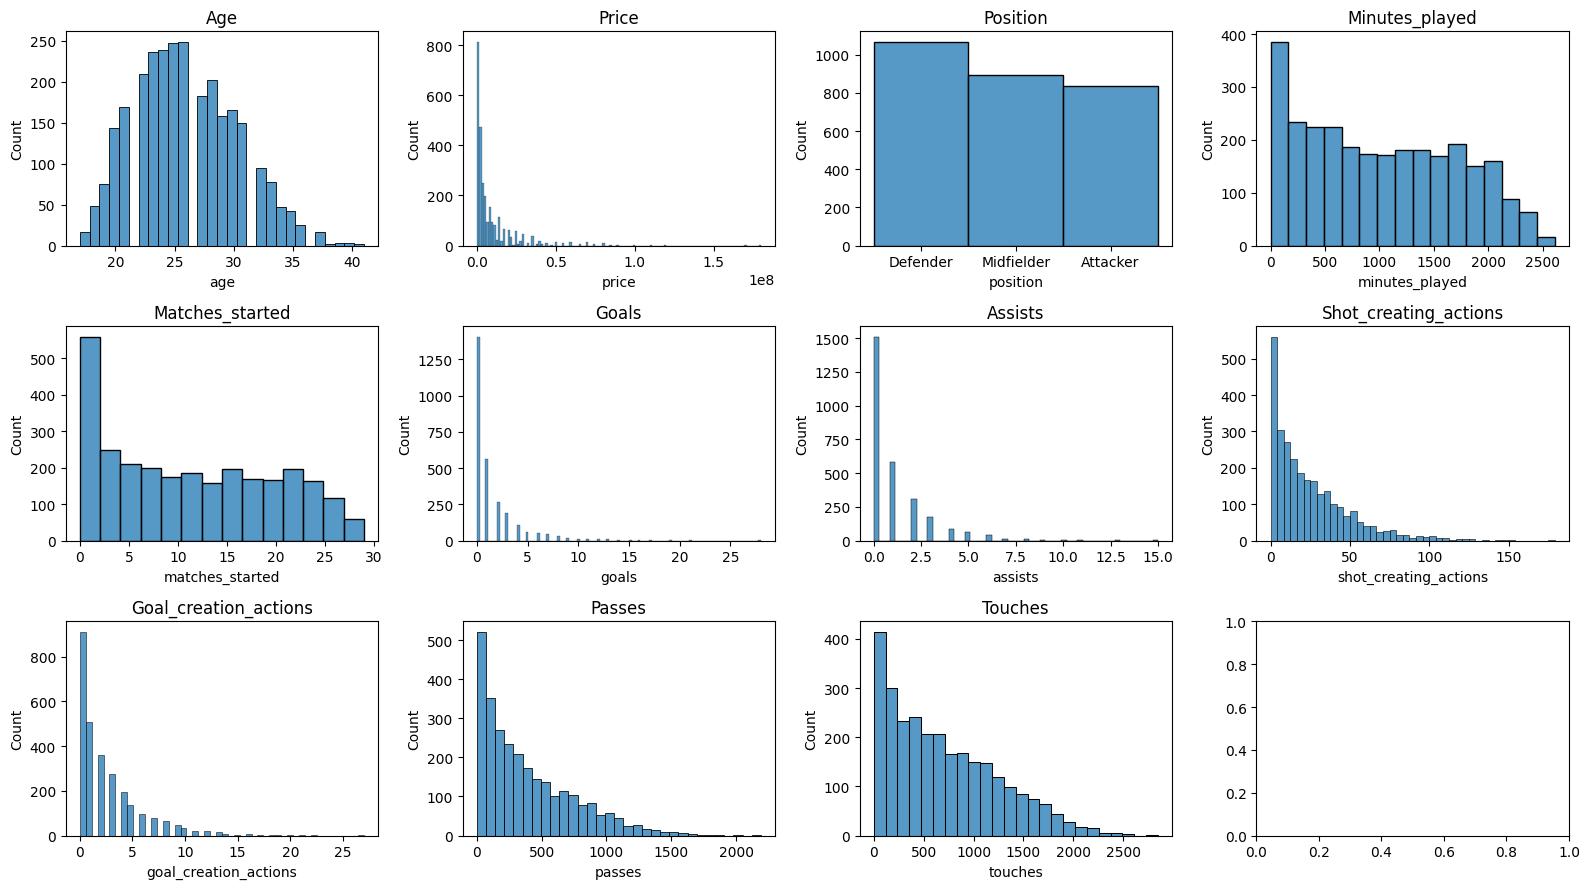

In [182]:
fig, axes = plt.subplots(3, 4, figsize=(16, 9))
axes = axes.ravel()

for i, feature in enumerate(features_of_interest):
    sns.histplot(data=df, x=feature, ax=axes[i], kde=False)
    axes[i].set_title(feature.capitalize())
    

fig.tight_layout()

plt.show()

The showcased graphs, excluding age and position, are right-skewed. Age is approximately normally distributed with a mean of 25-26. The most common players are defenders, followed by midfielders, and finally attackers. The large number of players with low playing times can be explained by the approximately 9 bench players that get very little playing time per game. This can also be applied to the games started statistics, as players who are not starters rarely receive the opportunity to do so. With most players being defenders and midfielders, who have limited opportunity to score and assist goals, it is clear why those two graphs have a heavy emphasis on the low values. The final four graphs’ right skew can also be explained by the bench players. 

#### Distribution of Class Label

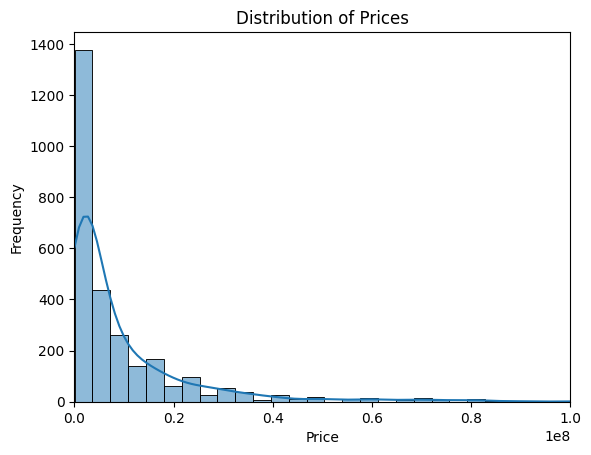

In [183]:
sns.histplot(data=df, x='price', bins=50, kde=True)
plt.title('Distribution of Prices')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.xlim(0, 100000000) 
plt.show()

#### Histogram of Features of Interest by Position

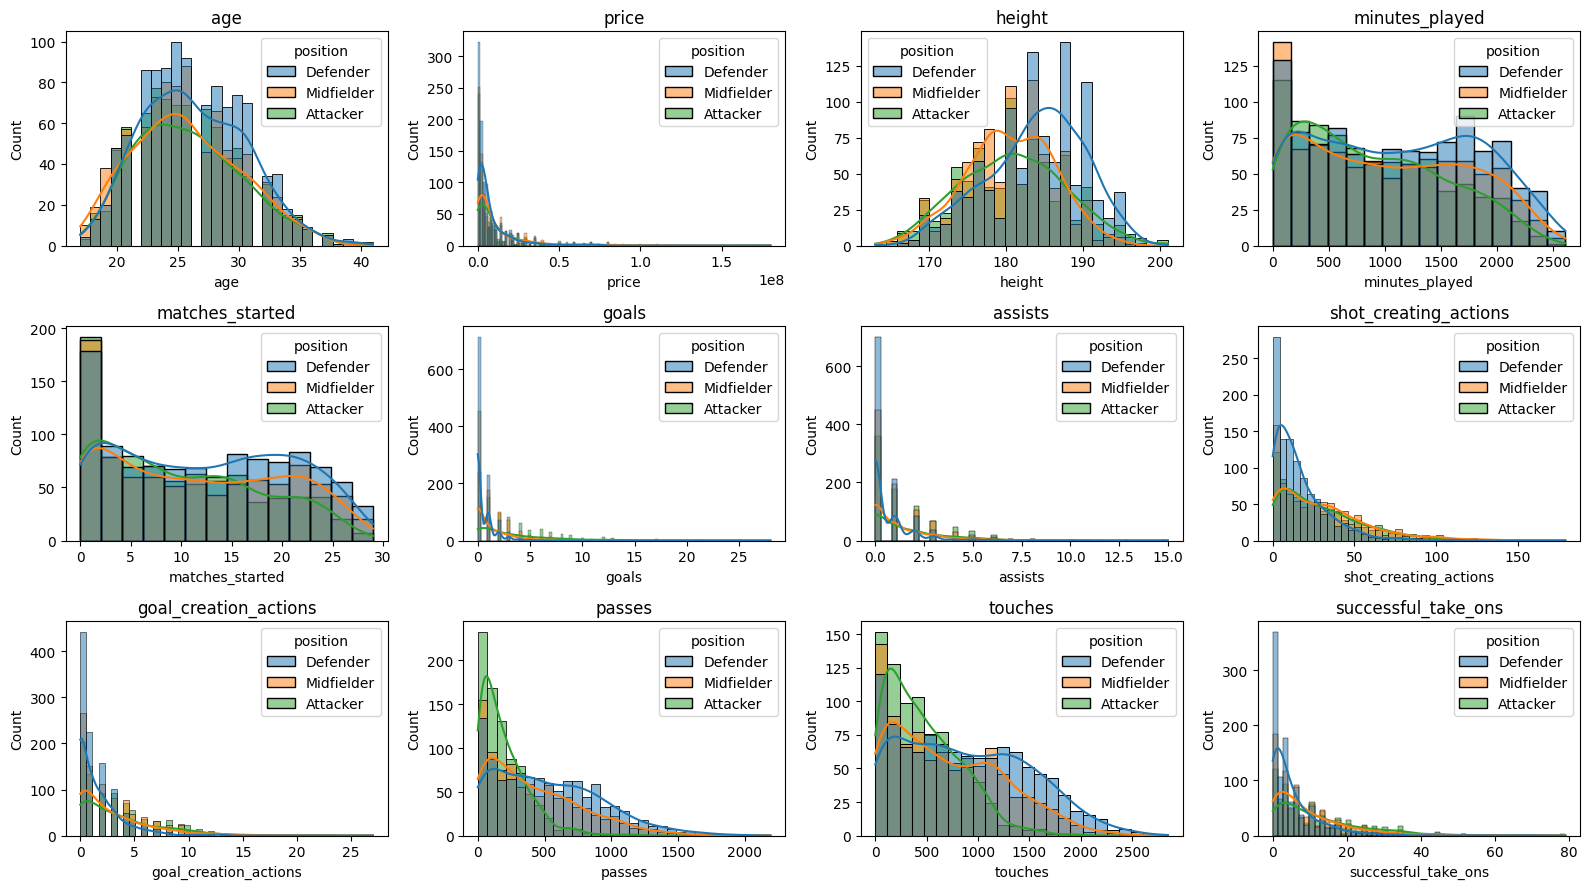

In [184]:
fig, axes = plt.subplots(3, 4, figsize=(16, 9))
axes = axes.ravel()

# Define the order of positions
position_order = ['Defender', 'Midfielder', 'Attacker']

# Iterate over each column and create a histogram sorted by player position
for i, column in enumerate(['age', 'price', 'height', 'minutes_played', 'matches_started', 'goals', 'assists', 'shot_creating_actions', 'goal_creation_actions', 'passes', 'touches', 'successful_take_ons']):
	sns.histplot(data=df, x=column, hue='position', hue_order=position_order, ax=axes[i], kde=True)
	axes[i].set_title(column)

# Adjust the layout of the subplots
fig.tight_layout()

# Show the plot
plt.show()


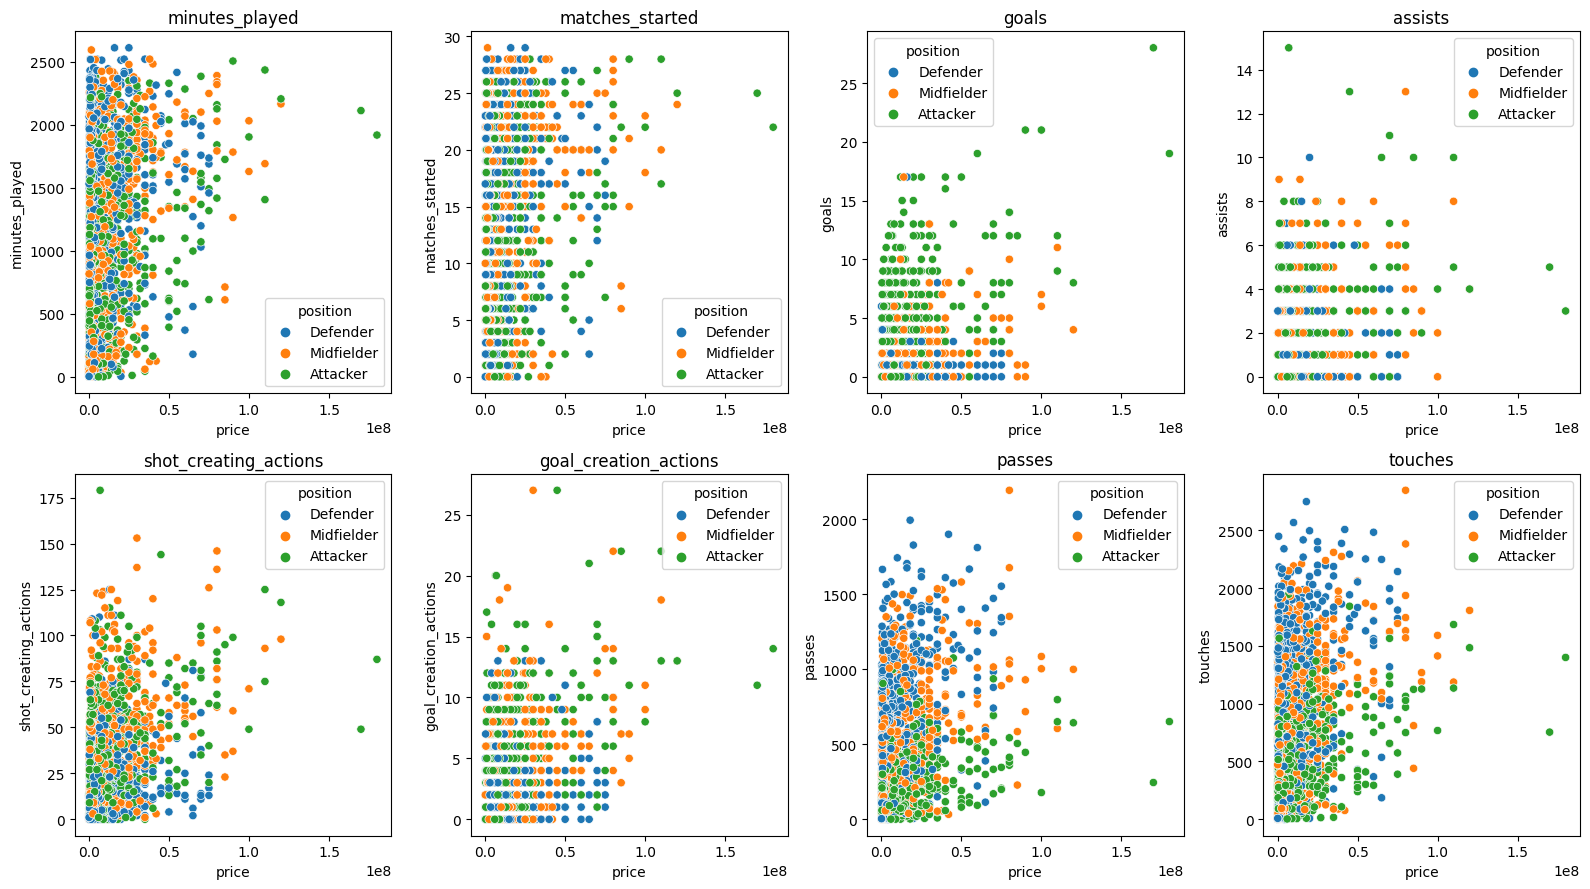

In [185]:
fig, axes = plt.subplots(2, 4, figsize=(16, 9))
axes = axes.ravel()

# Define the order of positions
position_order = ['Defender', 'Midfielder', 'Attacker']

for i, column in enumerate(['minutes_played', 'matches_started', 'goals', 'assists', 'shot_creating_actions', 'goal_creation_actions', 'passes', 'touches']):
    ax = sns.regplot(data=df, x='price', y=column, scatter_kws={'s': 10}, line_kws={}, ax=axes[i], ci=None, fit_reg=False)
    sns.scatterplot(data=df, x='price', y=column, hue='position', hue_order=position_order, ax=ax, legend=True)
    ax.set_title(column)

# Adjust the layout of the subplots
fig.tight_layout()

# Show the plot
plt.show()


In [186]:
df[features_of_interest].describe()

age         price  minutes_played  matches_started  \
count  2800.000000  2.800000e+03     2800.000000      2800.000000   
mean     25.948214  9.651884e+06     1012.769643        11.332857   
std       4.343647  1.519840e+07      697.801611         8.331035   
min      17.000000  2.500000e+04        1.000000         0.000000   
25%      23.000000  1.400000e+06      386.000000         4.000000   
50%      26.000000  4.000000e+06      959.500000        11.000000   
75%      29.000000  1.200000e+07     1605.500000        19.000000   
max      41.000000  1.800000e+08     2610.000000        29.000000   

             goals      assists  shot_creating_actions  goal_creation_actions  \
count  2800.000000  2800.000000            2797.000000            2797.000000   
mean      1.511786     1.033571              24.597426               2.547372   
std       2.608531     1.607508              24.070286               3.215828   
min       0.000000     0.000000               0.000000               0.000000   
25%       0.000000     0.000000               6.000000               0.000000   
50%       0.000000     0.000000              17.000000               1.000000   
75%       2.000000     2.000000              36.000000               4.000000   
max      28.000000    15.000000             179.000000              27.000000   

            passes      touches  
count  2797.000000  2797.000000  
mean    393.254916   702.207365  
std     357.974177   551.631279  
min       0.000000     0.000000  
25%     105.000000   230.000000  
50%     288.000000   594.000000  
75%     608.000000  1079.000000  
max    2192.000000  2846.000000

### Observations
    
- The average age of a player in the top 7 European leagues is 25.9. This shows the inclination of clubs to promote youth players given that the common retirement age is about 35 years of old. 
- The average price of the players in our dataset is 9.6 million Euro's! This is a surprising figure given the total outlay of transfer fees that clubs normally spend. It is also important to note that the standard deviation of our class label is about 15 million Euro's, which is substantial. 
- Both goals and assists include 0 across their first and second quartile. We can conclude that the majority of players in our dataset have not scored or assisted this season.
- The average minutes played for all the players in the dataset is 1012 minutes - an insufficient amount of time to drive many statistics to a high-range.

In [187]:
features_of_interest.pop(features_of_interest.index('position'))

'position'

### Distribution of Features of Interest

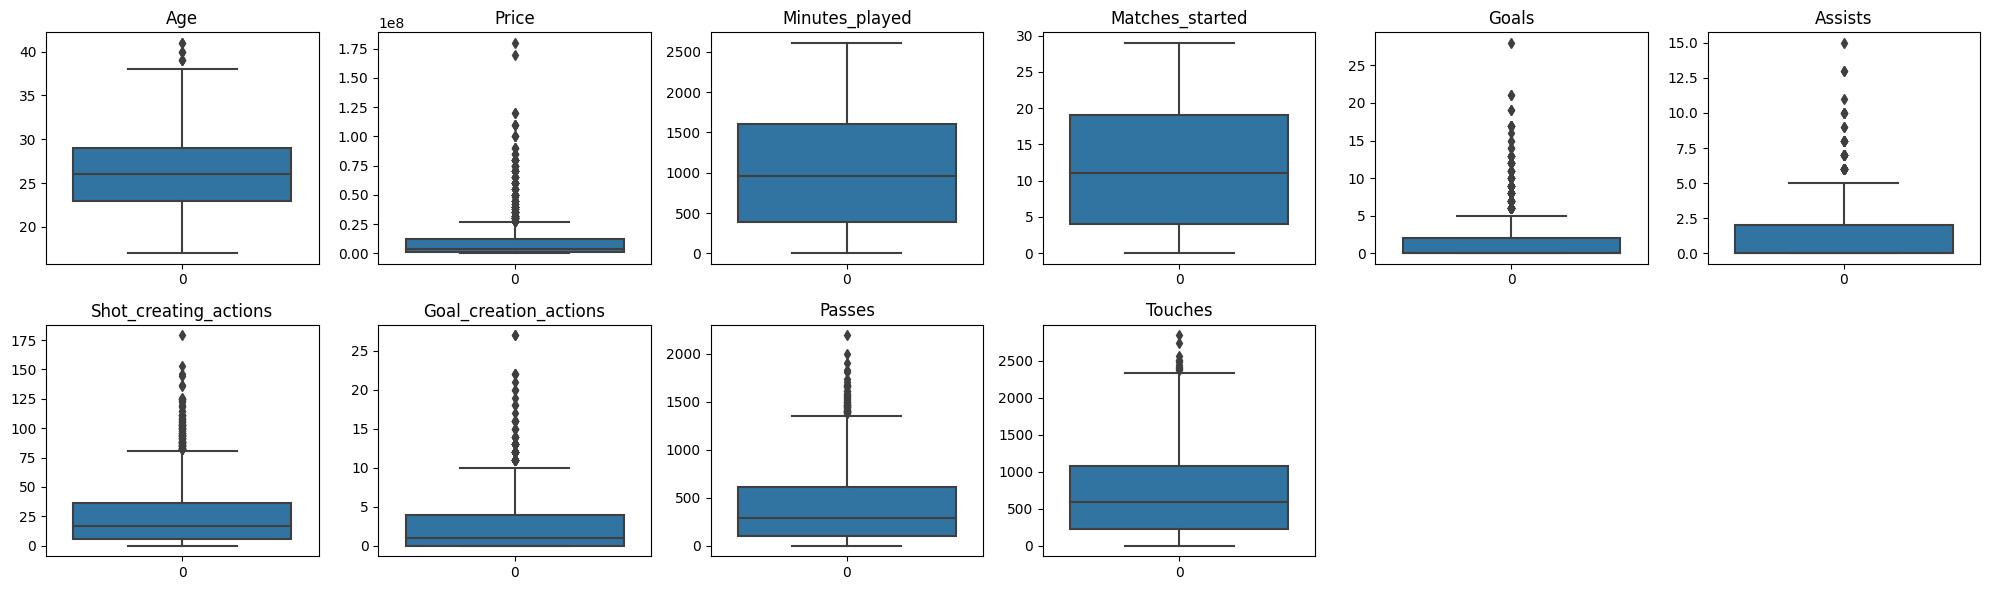

In [188]:
fig, axes = plt.subplots(nrows=2, ncols=6, figsize=(20, 6))

axes = axes.flatten()

for i, feature in enumerate(features_of_interest):

    if len(df[feature].unique()) > 1:
        
        sns.boxplot(ax=axes[i], data=df[feature], orient='v')
        axes[i].set_title(feature.capitalize())
        
for j in range(len(features_of_interest), len(axes)):
    fig.delaxes(axes[j])

fig.tight_layout()
plt.show()

### Observations

- Price contains a lot of outliers in the dataset. These are the superstar players, who's price could be inflated through other factors such as marketing prowess, nationality, or the club that they belong to. (some smaller clubs value important players higher to retain their services)
- Goals and assists also contain many outliers with a handful of players exceeding the IQR range. 
- The same observation follows for the shot and goal creating actions - there are many above-average players that are generating more than the average player in the dataset.
- The minutes and matches played follow an even distribution which is expected as there are about 22 calendar games played thus far for this dataset.
- The removal of outliers may benefit the model, especially within the *price* feature.

### Scatter Plot Correlations with the Class Variable

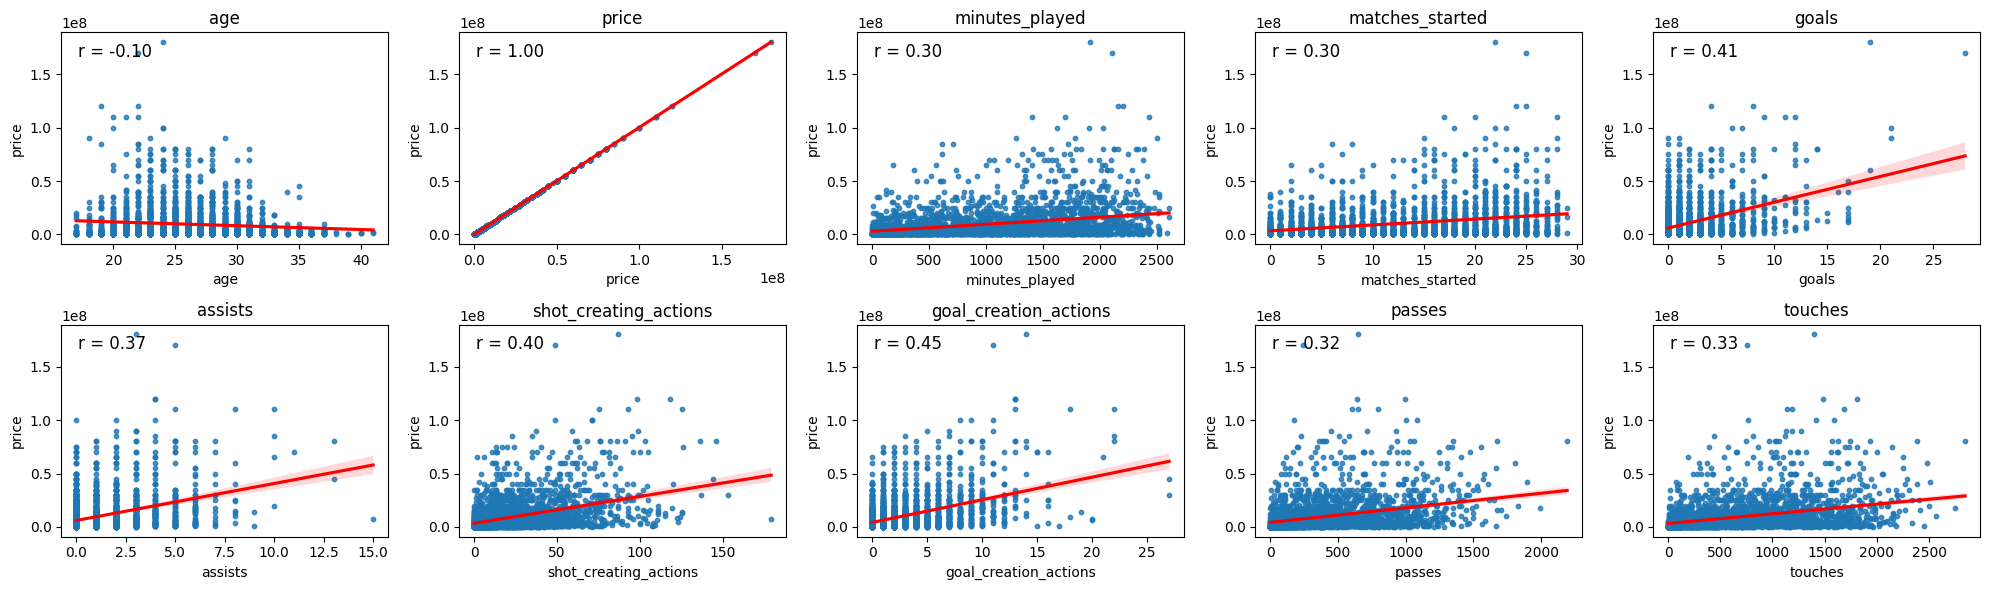

In [189]:
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(20, 6))

axes = axes.flatten()
for i, feature in enumerate(features_of_interest):

    sns.regplot(ax=axes[i], x=feature, y='price', data=df, scatter_kws={'s':10}, line_kws={'color':'red'})
    axes[i].set_title(feature)
    
    corr_coef = df[feature].corr(df['price'])
    axes[i].text(0.05, 0.95, f'r = {corr_coef:.2f}', transform=axes[i].transAxes, ha='left', va='top', fontsize=12)
    
fig.tight_layout()
plt.show()


### Observations

- It is interesting to note that age may be completely independent of a player's value as per the weak r-score of -0.10. This indicates that a player's value decreases slightly with age. A possible explanation for this may be that a club may value experience over youth development, therefore valuing an experienced player more highly. In additon, it could be that a younger player has potential to grow increasing their value, but an experienced player is more established within the game, creating a conflict between the determination of value.
- Goals, shot & goal creating actions showed a weak, positive correlation with player value with scores greater than 0.4. 
- Overall, there isn't a specific feature that shows a strong, positive or negative correlation with the class variable, which may impact the accuracy of the regression model. 

### Heatmap of Variable Correlations

<AxesSubplot:>

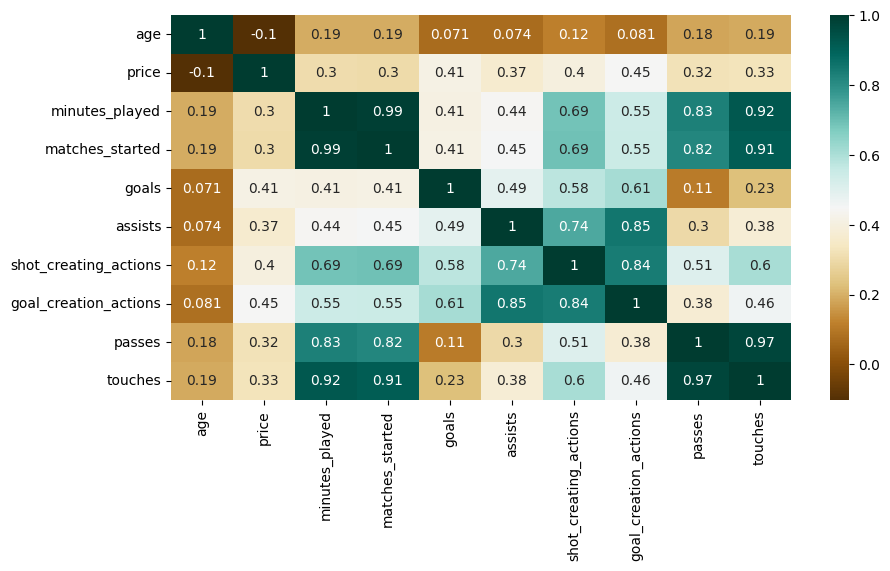

In [190]:
plt.figure(figsize=(10,5))
c= df[features_of_interest].corr()
sns.heatmap(c,cmap="BrBG",annot=True)

#### Observations
 
- Age is not strongly correlated with any of the other features. The largest correlation values were with minutes and matches played as well as passes and touches.
- Price had a correlation between 0.3 and 0.45 for all features except for age. 
- Some of the strongest correlations were between minutes played and matches started. These two features each had very strong correlations between passes and touches. This is not a surprise as intuitively the more a player plays, the more they will touch and pass the ball.
- One of the more surprising correlations was with goal creation actions and goals. It was expected that a player that has more actions creating a goal would score more goals. Similarly, shot creating actions was expected to have a stronger correlation with goals than seen in the heatmap.
- Interestingly, passes only had a correlation value of 0.3 with assists. Considering an assist can only occur from a pass, it was predicted that the heat map would have contained a higher value between these two features.

## Player Play Style - A Clustering Algorithm <a class="anchor" id="clustering"></a>

In [191]:
color_theme = np.array(['#006AA3','#CF2626','#06893A'])

#### Objective

The goal of the clustering algorithm is to assign labels to players based on their playing style using their in-game statistics as the primary input. In other words, the algorithm will analyze players' performance data to identify patterns and group them together based on their playing style.

In [192]:
# Limit the dataset to only playing statistics.
player_performance_stats = df.columns[12:23]

# Store in player_stats_df
player_stats_df = df[player_performance_stats]

In [193]:
player_stats_df.count()

tackles_won                2800
shot_creating_actions      2797
goal_creation_actions      2797
fouls                      2800
aerial_duels_won           2797
assists                    2800
progressive_passes         2797
successful_take_ons        2797
total_carrying_distance    2797
goals                      2800
total_shots                2800
dtype: int64

In [194]:
# Coincidentally, by dropping the null in the 'shot_creating_actions' feature, we drop the nulls in other features as well.
player_stats_df = player_stats_df[~player_stats_df['shot_creating_actions'].isna()]

In [195]:
# Scale the data to have 0 mean and unit variance (i.e., variance=1).
# 'Streamlines the distance calculation => each feature has the same "weight".' - MSCI 446 Tutorial 3
scaled_data = scale(player_stats_df)
variable_names = player_stats_df.columns

X = pd.DataFrame(scaled_data, columns=variable_names)

In [196]:
X.head()

tackles_won  shot_creating_actions  goal_creation_actions     fouls  \
0     1.617855              -0.440349              -0.792277  0.510880   
1     0.394899              -0.814321              -0.792277  1.160859   
2    -0.522318              -0.897425              -0.792277 -0.510515   
3    -1.133796              -1.022083              -0.792277 -1.253347   
4    -0.624231              -0.938978              -0.481260 -0.324807   

   aerial_duels_won   assists  progressive_passes  successful_take_ons  \
0          0.762233 -0.643567            0.021876            -0.663130   
1          4.122442 -0.643567           -0.197255            -0.861427   
2          0.762233 -0.643567           -0.635517            -0.861427   
3         -0.775489 -0.643567           -1.049431            -0.861427   
4         -0.661584 -0.643567           -0.830300            -0.663130   

   total_carrying_distance     goals  total_shots  
0                -0.268669  0.953085    -0.202619  
1                -0.554192 -0.580073    -0.530280  
2                -0.813601 -0.196784    -0.661345  
3                -1.146131 -0.580073    -0.923475  
4                -0.872215 -0.580073    -0.857942

#### Elbow Method

We will leverage the elbow method to find the optimal number of clusters before adding another cluster that doesn't give much better modeling of the data.

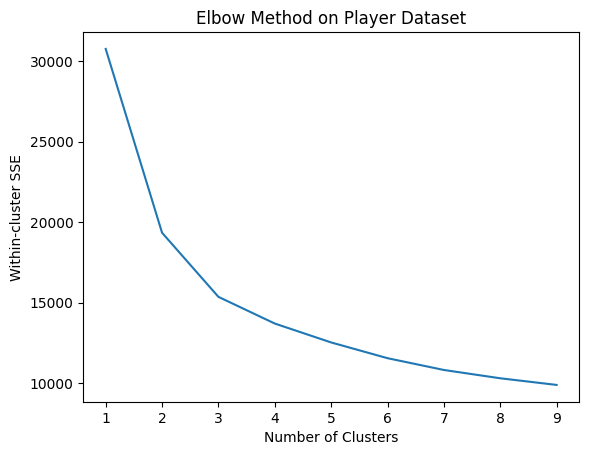

In [197]:
distortations = {}

max_n_clusters = 10

for k in range(1, max_n_clusters):
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(X)
    distortations[k] = kmeans.inertia_

plt.plot(list(distortations.keys()), 
         list(distortations.values()))
plt.title('Elbow Method on Player Dataset')
plt.xlabel('Number of Clusters')
plt.ylabel('Within-cluster SSE')
plt.show()

Using the elbow method and plotting the within-cluster sum of squares against the number of clusters helps prevent overfitting or underfitting from occurring.  It is seen that the optimal number of clusters needed is between 2 and 3 as there are two bends. This is the point of diminishing returns as any more clusters will not lead to a significant increase in the performance of the algorithm.

In [198]:
# Print the difference in within-cluster SSE
print("Difference in within-cluster SSE:")
for k in range(1, max_n_clusters - 1):
    print("{} - {}: {}"
          .format(k, k + 1, distortations[k] - distortations[k + 1]))

Difference in within-cluster SSE:
1 - 2: 11419.358362632272
2 - 3: 3982.2555229069567
3 - 4: 1657.8826600358589
4 - 5: 1174.065146005545
5 - 6: 977.5608448177718
6 - 7: 732.3666857057924
7 - 8: 515.8252556189673
8 - 9: 412.3972396023746


We can see that the more clusters are added to the model, the less average distance from each cluster mean that a given datapoint will have.

In [199]:
kl = KneeLocator(
    list(distortations.keys()), 
    list(distortations.values()), 
    curve="convex", 
    direction="decreasing"
)

# the elbow attribute stores the optimal # of clusters
kl.elbow

3

By leveraging the kneed library,it is seen that the optimal number of clusters needed is 3. This is the point of diminishing returns as any more clusters will not lead to a significant increase in the performance of the clustering.

In [200]:
# Creating clusters object with 3 clusters.
clustering  = KMeans(n_clusters=3,random_state=5)

clustering.fit(X)
clustering.labels_

array([2, 2, 1, ..., 0, 1, 1], dtype=int32)

#### Comparing Polar Statistics 

As a next step, we need to determine from our domain knowledge, how the clusters were formed. To visually evaluate the clustering labels, we evaluate the features against each other with the class label as the hue or differentiator.

In [201]:
# Appending resulting labels to a result_df.
cluster_labels = pd.Series(clustering.labels_, name='cluster_label')
result_df = pd.concat([X, cluster_labels], axis=1)

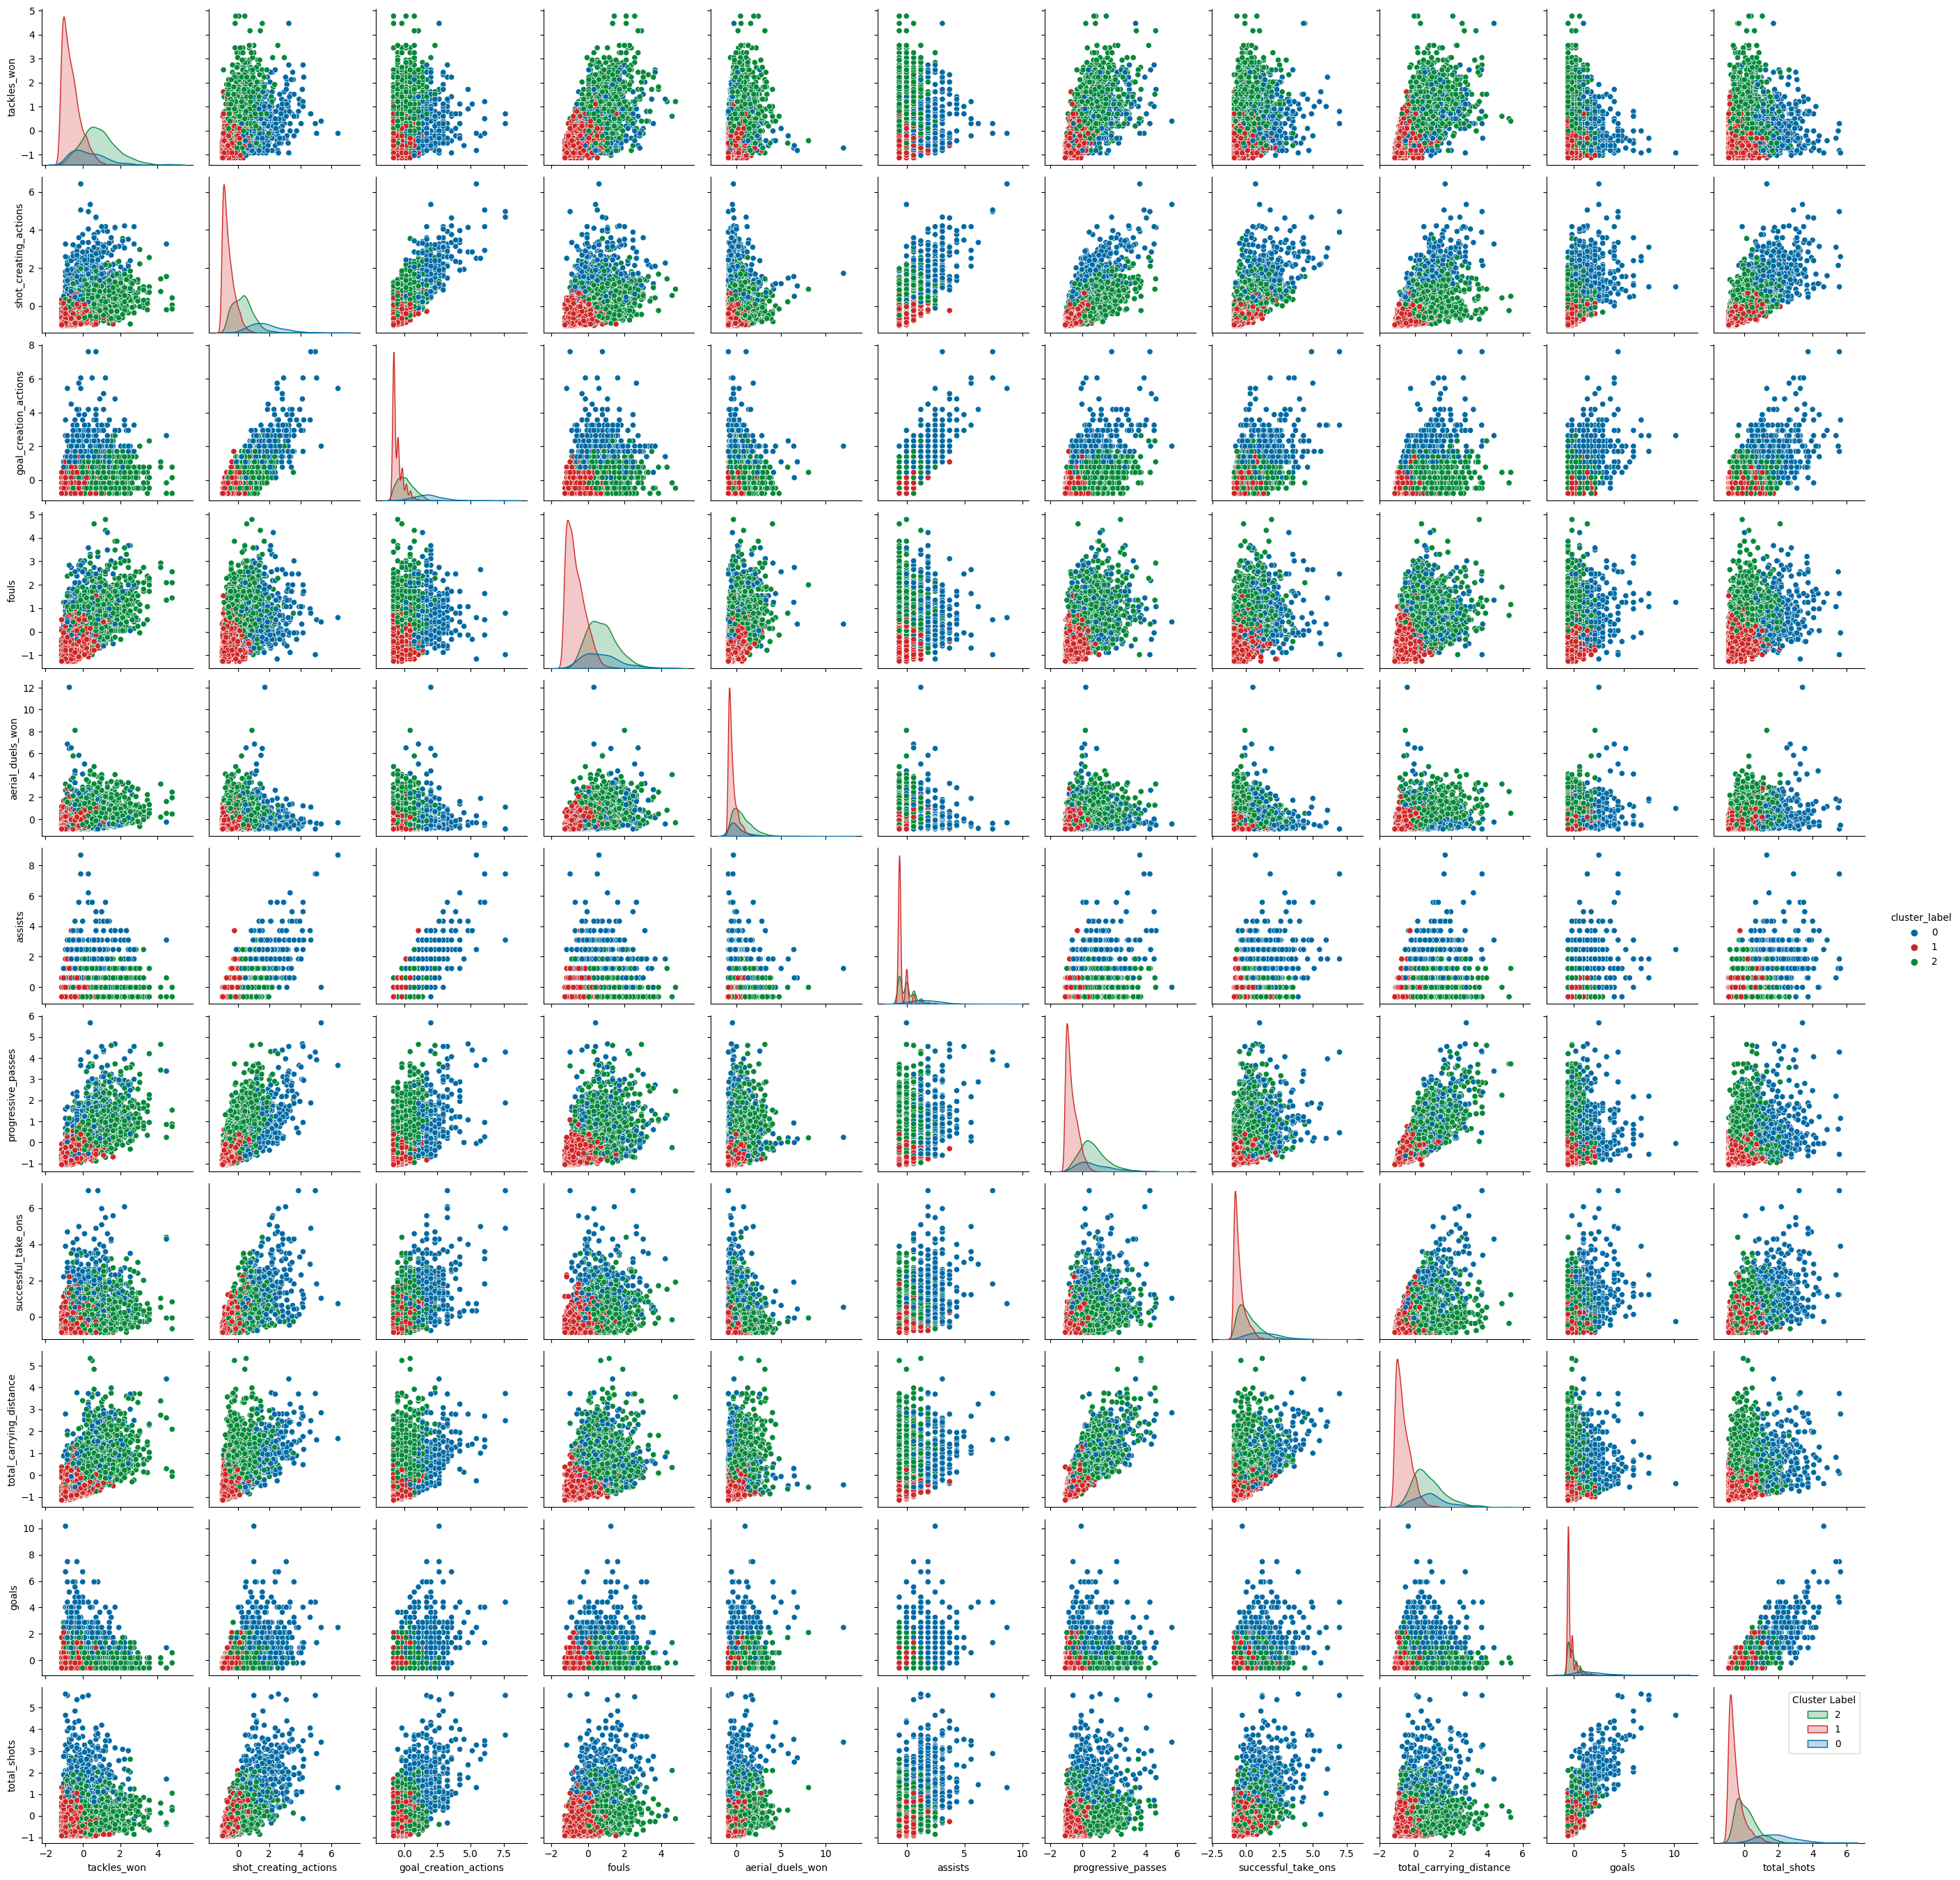

In [202]:
sns.pairplot(result_df, hue='cluster_label', palette=color_theme.tolist())
labels = result_df['cluster_label'].unique()
plt.legend(title='Cluster Label', labels=labels)
plt.show()

As per the visuals, the clustering algorithm groups each player by the quantity in each statistic. This may mean that, instead of grouping by player play-style, the clustering algorithm is ranking by quallity of player. From domain knowledge, the orange, green, and blue colors represent inferior, average, and superior players respectively. 

Clustering Group 0 (blue) describes superstar players - players who have a high quantity of playing statistics such as goals, shots/goals created, and progressive passes. 

Clustering Group 1 (red) and Clustering Group 2 (green) are much more close and similar than the distinction to the 0 class. However, it is clear from the plots that Group 2 (green) has slightly better performance metrics across all the statistics than Cluster Group 1 (red).

This is a further evidence, that the clustering algorithm grouped by player ability, with the ability ranked from cluster label 0, 2, 1 respectively. 

To prove this theory, we will group by cluster label and inspect by the distribution of price and/or other player statistics.

In [203]:
result_df.head()

tackles_won  shot_creating_actions  goal_creation_actions     fouls  \
0     1.617855              -0.440349              -0.792277  0.510880   
1     0.394899              -0.814321              -0.792277  1.160859   
2    -0.522318              -0.897425              -0.792277 -0.510515   
3    -1.133796              -1.022083              -0.792277 -1.253347   
4    -0.624231              -0.938978              -0.481260 -0.324807   

   aerial_duels_won   assists  progressive_passes  successful_take_ons  \
0          0.762233 -0.643567            0.021876            -0.663130   
1          4.122442 -0.643567           -0.197255            -0.861427   
2          0.762233 -0.643567           -0.635517            -0.861427   
3         -0.775489 -0.643567           -1.049431            -0.861427   
4         -0.661584 -0.643567           -0.830300            -0.663130   

   total_carrying_distance     goals  total_shots  cluster_label  
0                -0.268669  0.953085    -0.202619              2  
1                -0.554192 -0.580073    -0.530280              2  
2                -0.813601 -0.196784    -0.661345              1  
3                -1.146131 -0.580073    -0.923475              1  
4                -0.872215 -0.580073    -0.857942              1

In [204]:
result_df = result_df.join(df[['position', 'price', 'name']], how='inner')

In [205]:
result_df.head()

tackles_won  shot_creating_actions  goal_creation_actions     fouls  \
0     1.617855              -0.440349              -0.792277  0.510880   
1     0.394899              -0.814321              -0.792277  1.160859   
2    -0.522318              -0.897425              -0.792277 -0.510515   
3    -1.133796              -1.022083              -0.792277 -1.253347   
4    -0.624231              -0.938978              -0.481260 -0.324807   

   aerial_duels_won   assists  progressive_passes  successful_take_ons  \
0          0.762233 -0.643567            0.021876            -0.663130   
1          4.122442 -0.643567           -0.197255            -0.861427   
2          0.762233 -0.643567           -0.635517            -0.861427   
3         -0.775489 -0.643567           -1.049431            -0.861427   
4         -0.661584 -0.643567           -0.830300            -0.663130   

   total_carrying_distance     goals  total_shots  cluster_label  position  \
0                -0.268669  0.953085    -0.202619              2  Defender   
1                -0.554192 -0.580073    -0.530280              2  Defender   
2                -0.813601 -0.196784    -0.661345              1  Defender   
3                -1.146131 -0.580073    -0.923475              1  Defender   
4                -0.872215 -0.580073    -0.857942              1  Defender   

     price                 name  
0  5000000        Erhan Masovic  
1  3500000          Ivan Ordets  
2  3000000  Keven Schlotterbeck  
3  3000000  Keven Schlotterbeck  
4  1500000     Dominique Heintz

#### Comparing Cluster Label with Player Position

In [206]:
counts = result_df.groupby(['cluster_label', 'position']).size()
counts

cluster_label  position  
0              Attacker      156
               Defender       41
               Midfielder    161
1              Attacker      449
               Defender      580
               Midfielder    469
2              Attacker      229
               Defender      448
               Midfielder    264
dtype: int64

In [207]:
positions = counts.unstack().columns

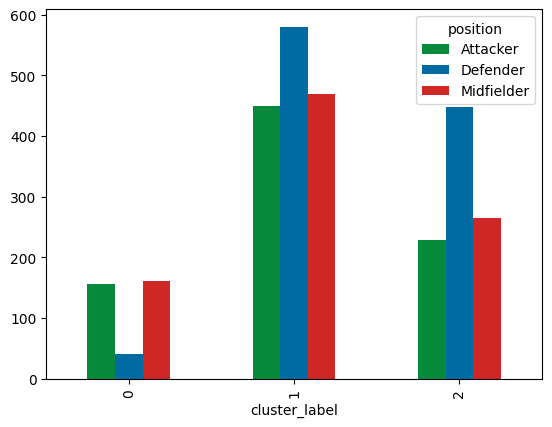

In [208]:
colors = {'Defender': color_theme[0], 'Midfielder': color_theme[1], 'Attacker': color_theme[2]}
counts.unstack().plot(kind='bar', color=[colors.get(x) for x in positions])
plt.show()

There is no clear distinction of the number of positions per cluster label. This could mean that the clustering algorithm did not group the clusters based on playing-style as intended. If there was a high ratio of players in a specific cluster that played a specific position, we could be able to conclude that the clustering grouped players by playing-style of position.

#### Comparing Cluster Label with Player Price

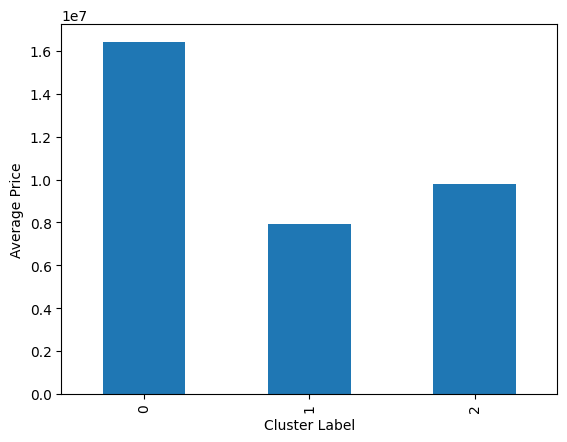

In [209]:
grouped = result_df.groupby('cluster_label')['price'].mean()

grouped.plot(kind='bar')
plt.xlabel('Cluster Label')
plt.ylabel('Average Price')
plt.show()

From this comparison with price, we can determine that the clustering label '0' contains high-performing players that have a high-transfer value compared with players in cluster groups 1 and 2. We can also conclude that the clustering algorithm grouped players based on general ability, as opposed to playing-style. Our pair-plot visuals also confirmed an extreme grouping of players based on ability, with a clear distinction of players with a a high, medium, or low number of statistics. This plot confirms that cluster group 0 represents a high-calibre of player compared to 1 and 2. Cluster Group 2 represented players with a slightly better ability than cluster group 1, but slightly worse than cluster group 0.

In conclusion, we plan to label the cluster results as follows:
    
- Cluster Group 0: Superstars
- Cluster Group 2: Average Players
- Cluster Group 1: Inferior Players

We will refine the dataset according to the proposed labels.

In [210]:
position_mappings = {0: 'Superstar', 1: 'Inferior Player', 2: 'Average Player'}

# Map positions to roles using the position_roles dictionary
result_df['cluster_label'] = result_df['cluster_label'] .map(position_mappings)

In [211]:
result_df.head()

tackles_won  shot_creating_actions  goal_creation_actions     fouls  \
0     1.617855              -0.440349              -0.792277  0.510880   
1     0.394899              -0.814321              -0.792277  1.160859   
2    -0.522318              -0.897425              -0.792277 -0.510515   
3    -1.133796              -1.022083              -0.792277 -1.253347   
4    -0.624231              -0.938978              -0.481260 -0.324807   

   aerial_duels_won   assists  progressive_passes  successful_take_ons  \
0          0.762233 -0.643567            0.021876            -0.663130   
1          4.122442 -0.643567           -0.197255            -0.861427   
2          0.762233 -0.643567           -0.635517            -0.861427   
3         -0.775489 -0.643567           -1.049431            -0.861427   
4         -0.661584 -0.643567           -0.830300            -0.663130   

   total_carrying_distance     goals  total_shots    cluster_label  position  \
0                -0.268669  0.953085    -0.202619   Average Player  Defender   
1                -0.554192 -0.580073    -0.530280   Average Player  Defender   
2                -0.813601 -0.196784    -0.661345  Inferior Player  Defender   
3                -1.146131 -0.580073    -0.923475  Inferior Player  Defender   
4                -0.872215 -0.580073    -0.857942  Inferior Player  Defender   

     price                 name  
0  5000000        Erhan Masovic  
1  3500000          Ivan Ordets  
2  3000000  Keven Schlotterbeck  
3  3000000  Keven Schlotterbeck  
4  1500000     Dominique Heintz

In [212]:
labels = list(result_df.cluster_label.unique())
labels

['Average Player', 'Inferior Player', 'Superstar']

Let's confirm our theory that the clustering algorithm groups on player ability, by comparing the distribution of price in accordance to each resulting label. 

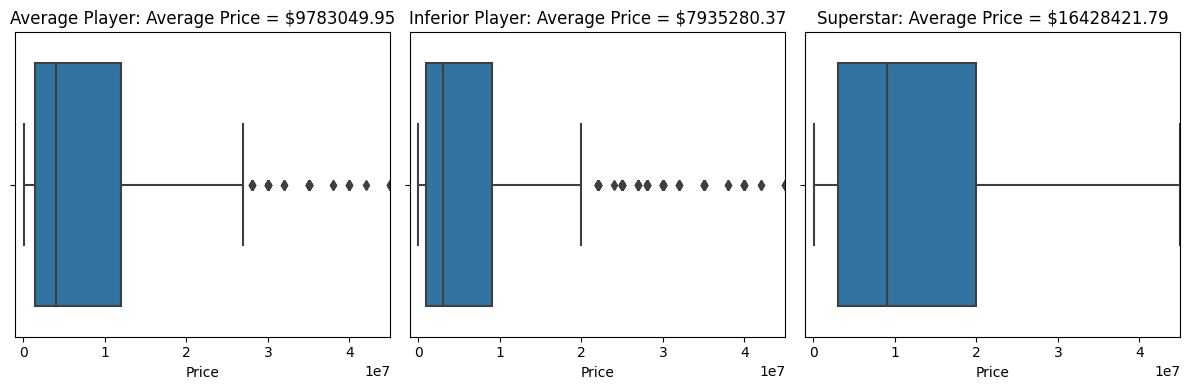

In [213]:
# Create a figure with three subplots.
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(12,4))

# Create three boxplots, one for each cluster label
for label, ax in zip(['Average Player', 'Inferior Player', 'Superstar'], axes):
    # Filter the data for the current cluster label
    data = result_df[result_df['cluster_label'] == label]
    
    # Calculate the average price for the current cluster label
    avg_price = data['price'].mean()
    
    # Create a boxplot for the current cluster label
    sns.boxplot(x=data['price'], ax=ax)
    ax.set_title(f'{label}: Average Price = ${avg_price:.2f}')
    ax.set_xlabel('Price')
    ax.set_ylabel('')
    
    # Set the x-axis limits to zoom in on prices between $0 and $500
    ax.set_xlim(-1000000, 45000000)
    
plt.tight_layout()
plt.show()

This plots help confirm that the class labels are correlated with player ability. The higher the class label ranking the higher the average price of the players pertaining to that ranking.

## Predicting Player Play Style by Linear Regression <a class="anchor" id="linear-regression"></a>

### First Iteration - Initial Dataset

We will start building the optimal linear regression model with our features of interest and continually increment the number of features as needed. These features show relevant correlation as per our initial scatter plots in the data exploration stage.

In [216]:
features = [
    'age', 
    'minutes_played',
    'matches_played',
    'matches_started',
    'shot_creating_actions',
    'goal_creation_actions',
    'assists',
    'progressive_passes',
    'total_carrying_distance',
    'goals',
    'total_shots',
    'passes', 
    'touches',
    'Attacker',
    'Defender',
    'Midfielder',
]

#### Dropping Nulls

We will perform the dropping of nulls for every iteration of the model we build as to focus on the features that require the dropping of nulls. In our case, we will have to drop the null values from the features selected. Replacing null values with the mean or median of the feature is not appropriate in this case because it will affect that observation's correlation with player value.

In [217]:
df.dropna(subset=['shot_creating_actions'], inplace=True)

# shot_creating_actions' null values also aligned with the other columns' null values.

In [218]:
X = df[features]
y = df['price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [219]:
X_train.shape

(2237, 16)

In [220]:
lreg = LinearRegression()
lreg.fit(X_train, y_train)

LinearRegression()

#### Coefficients

In [221]:
coefficients = pd.DataFrame(lreg.coef_, features, columns = ['Coeff']).sort_values(by='Coeff', ascending=False)
coefficients

Coeff
goal_creation_actions    1.486452e+06
goals                    1.415580e+06
Midfielder               1.049003e+06
Attacker                 4.194874e+05
total_shots              2.079163e+05
passes                   4.092531e+04
total_carrying_distance  6.048728e+02
minutes_played          -3.797223e+03
touches                 -5.777199e+03
shot_creating_actions   -6.622141e+03
progressive_passes      -1.051609e+05
assists                 -1.351385e+05
matches_started         -2.896329e+05
matches_played          -3.153325e+05
age                     -5.282877e+05
Defender                -1.468490e+06

From this initial iteration, there are both surprising and expected results. 

It is expected that goal_creating_actions, goals, and total_shots increase the value of a player the most relative to the other features. Generally, in the soccer community, the goal-outlook of a player will increase their value. Goals and assists are the primary metric of a prolific and valuable soccer player. It also makes sense that Attackers and Midfielders have added value compared to Defenders. Defenders are typically valued lowered because they are not directly contributing to goals or assists. Midfielders and Attackers on the other hand, are actively involved, and therefore valued higher compared to defenders. Age having a negative coefficent also makes sense, as the more a player ages, the closer they are to retirement, and therefore the less they are valued overall.

It was surprising to see that value decreases with positive statistics, such as progressive_passes, touches, and assists. The algorithm is probably accounting for defender and midfielders, who have the majority of their positive statistics associated with passing, touches, and minutes played.  

In [222]:
predictions = lreg.predict(X_test)

#### Actual vs Predicted Player Value

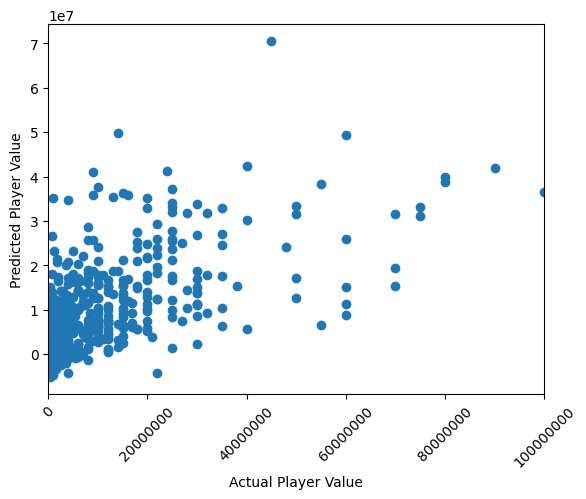

In [229]:
plt.scatter(y_test, predictions)
plt.ticklabel_format(style='plain', axis='x')
plt.xlabel('Actual Player Value')
plt.ylabel('Predicted Player Value')
plt.xticks(rotation=45) 
plt.xlim(0, 100000000)  # set the limits for the x-axis
plt.show()

#### Visualizing the Residuals

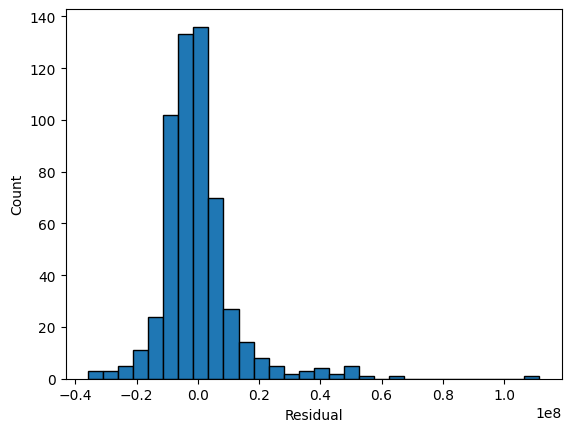

In [231]:
plt.hist(y_test - predictions, edgecolor='black', bins=30)  # increase the bins to 20
plt.ylabel("Count")
plt.xlabel("Residual")
plt.show()


From the residual plot, it looks like the created algorithm is *overestimating* the player value. Most of the residual values are falling to the left of 0, indicating that most residuals are negative. 

#### Mean Absolute Error

In [232]:
metrics.mean_absolute_error(y_test, predictions)

7929914.769980492

#### Mean Squared Error

In [233]:
metrics.mean_squared_error(y_test, predictions)

159388405721906.03

#### Root-Mean Square

In [234]:
np.sqrt(metrics.mean_squared_error(y_test, predictions))

12624912.107492315

Our first step in working towards better accuracy and performance is to remove the outliers in the core features. By doing so, we will improve lineality in the model and remove the influence of extreme values in the regression model.

### Second Iteration - Removal of Outliers

We will leverage each feature's interquartile range to determine non-extreme values for each feature. 

In [235]:
features = [
    'age', 
    'minutes_played',
    'matches_played',
    'matches_started',
    'shot_creating_actions',
    'goal_creation_actions',
    'assists',
    'progressive_passes',
    'total_carrying_distance',
    'goals',
    'total_shots',
    'passes', 
    'touches',
    'Attacker',
    'Defender', 
    'Midfielder',
]

We will leverage the IQR of the dataset features to remove the outliers.

In [237]:
indices_to_drop = []

# Loop over each feature and find outliers using the IQR method
for feature in features:
    q1 = df[feature].quantile(0.25)
    q3 = df[feature].quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5*iqr
    upper_bound = q3 + 1.5*iqr
    # Find the indexes where the values are below or above the lower and upper bounds respectively.
    outliers = df[(df[feature] < lower_bound) | (df[feature] > upper_bound)].index
    # Add the indices to the indices_to_drop.
    indices_to_drop.extend(outliers)

# Drop duplicate indices and sort the list
indices_to_drop = list(set(indices_to_drop))
indices_to_drop.sort()

# Remove the rows containing outliers
df = df.drop(indices_to_drop).reset_index(drop=True)

# Print the number of rows dropped
print(f"Total rows dropped: {len(indices_to_drop)}")

Total rows dropped: 405


In [238]:
X = df[features]
y = df['price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [239]:
lreg = LinearRegression()
lreg.fit(X_train, y_train)

LinearRegression()

In [240]:
coefficients = pd.DataFrame(lreg.coef_, features, columns = ['Coeff']).sort_values(by='Coeff', ascending=False)
coefficients

Coeff
Attacker                 1.149857e+06
assists                  5.476461e+05
goals                    5.338090e+05
goal_creation_actions    4.567222e+05
total_shots              2.197512e+05
Midfielder               1.862527e+05
matches_started          1.183370e+05
passes                   4.003556e+04
shot_creating_actions    2.798309e+04
total_carrying_distance  7.122576e+01
minutes_played          -6.970696e+03
touches                 -8.891894e+03
progressive_passes      -6.387190e+04
matches_played          -1.944932e+05
age                     -3.542810e+05
Defender                -1.336109e+06

The coefficients are similar to the first iteration dataset.

It is much re-assuring to see that the assists, goals, goal/shot creating actions increase value sharply as they are expected to in real life. In addition, it is also re-assuring to see that the time a player plays (e.g. minutes_played, matches_played) increase the value of a player instead of decreasing as in the first iteration. This is positive, as one would expect a frequently-playing player to be highly-valued.

We will see positive attributes such as progressive_passes and touches bring down the value of a player. This, as mentioned, could be a result of the algorithm accounting for defender and midfielder players, who are not as valuable as attackers, and who's statistics revolve around the build-up of play such as progressive passes and touches. As stated in the data exploration, defender and midfielders have a lot of statistics revolved around build-up play such as touches and progressive passes, therefore the negative value associated with these statistics could be associated with the negative value of defender or midfielders in comparison to attackers.  

In [243]:
predictions = lreg.predict(X_test)

#### Actual v.s. Predicted Player Value

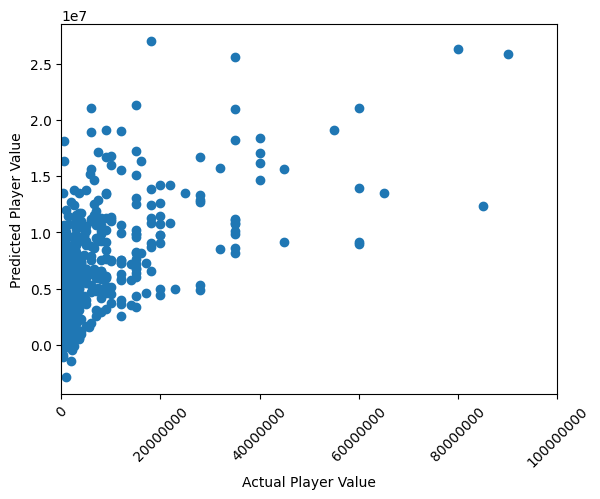

In [244]:
plt.scatter(y_test, predictions)
plt.ticklabel_format(style='plain', axis='x')
plt.xlabel('Actual Player Value')
plt.ylabel('Predicted Player Value')
plt.xticks(rotation=45) 
plt.xlim(0, 100000000)  # set the limits for the x-axis
plt.show()

#### Visualizing the Residuals

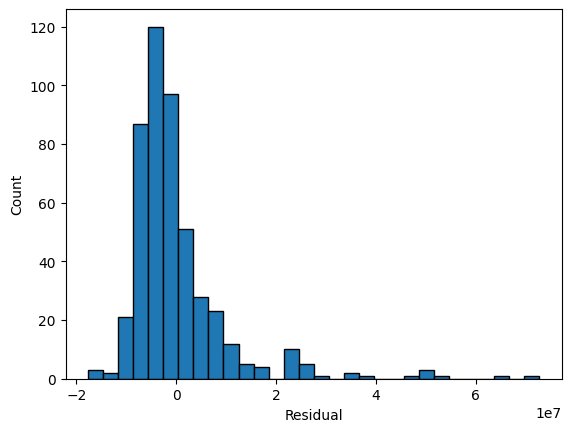

In [245]:
plt.hist(y_test - predictions, edgecolor='black', bins=30)  # increase the bins to 20
plt.ylabel("Count")
plt.xlabel("Residual")
plt.show()


The residual plot appears symmetrical - a good sign. However, we are still seeing a bias towards the overestimation of predicted values.

#### Mean Absolute Error

In [246]:
metrics.mean_absolute_error(y_test, predictions)

6342713.927173843

#### Mean Squared Error

In [247]:
metrics.mean_squared_error(y_test, predictions)

107124734926284.38

#### Root-Mean Square

In [248]:
np.sqrt(metrics.mean_squared_error(y_test, predictions))

10350107.966890218

### Third Iteration - Regression by Position

For this iteration, we will apply a linear regression to each distinct player position (attacker, midfielder, defender) to determine any changes to the ordering of the coefficients and performance of the model. We will also tailor the features to include each position's common traits and actions. This will hopefully tailor the model to the specific attributes for each statistic.

In [249]:
attackers = df[df['Attacker'] == 1]
midfielders = df[df['Midfielder'] == 1]
defenders = df[df['Defender'] == 1]

In [250]:
attacker_features = [
    'age', 
    'minutes_played',
    'matches_played',
    'matches_started',
    'shot_creating_actions',
    'goal_creation_actions',
    'assists',
    'progressive_passes',
    'total_carrying_distance',
    'goals',
    'total_shots',
    'passes', 
    'touches',
]

midfielder_features = [
    'age', 
    'minutes_played',
    'matches_played',
    'matches_started',
    'progressive_passes',
    'shot_creating_actions',
    'goal_creation_actions',
    'total_carrying_distance',
    'goals',
    'passes', 
    'touches',
    'both',
    'left', 
    'right',
    'fouls',
    'tackles_won',
    'defensive_actions',
]

defender_features = [
    'age', 
    'minutes_played',
    'matches_played',
    'matches_started',
    'progressive_passes',
    'total_carrying_distance',
    'goals',
    'passes', 
    'touches',
    'both',
    'left', 
    'right',
    'fouls',
    'tackles_won',
    'defensive_actions',
]

In [255]:
X = attackers[attacker_features]
y = attackers['price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
lreg = LinearRegression()
lreg.fit(X_train, y_train)
attacker_coefficients = pd.DataFrame(lreg.coef_, attacker_features, columns = ['Coeff']).sort_values(by='Coeff', ascending=False)
attacker_predictions = lreg.predict(X_test)

Text(0, 0.5, 'Predicted Player Value')

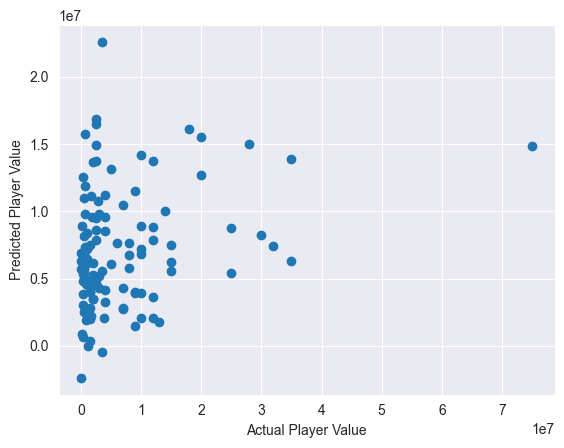

In [256]:
plt.scatter(y_test, attacker_predictions)
plt.xlabel('Actual Player Value')
plt.ylabel('Predicted Player Value')

#### Visualizing the Residuals

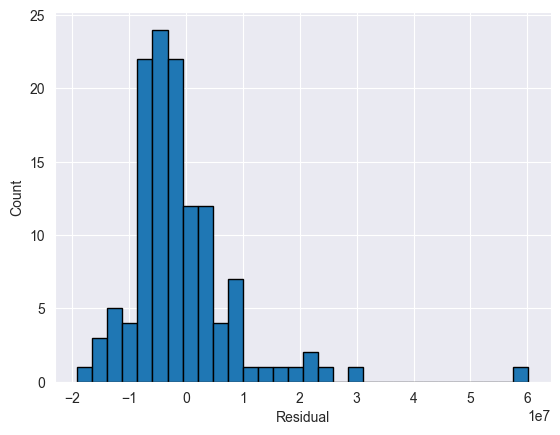

In [259]:
plt.hist(y_test - attacker_predictions, edgecolor='black', bins=30)  # increase the bins to 20
plt.ylabel("Count")
plt.xlabel("Residual")
plt.show()


The residuals seem to be in-line with the other iterations - symmetrical around 0 with a slight overestimation of the predicted values.

#### Mean Absolute Error

In [260]:
metrics.mean_absolute_error(y_test, attacker_predictions)

6489503.477358417

#### Mean Squared Error

In [261]:
metrics.mean_squared_error(y_test, attacker_predictions)

91006633763123.34

#### Root-Mean Square

In [262]:
np.sqrt(metrics.mean_squared_error(y_test, attacker_predictions))

9539739.711497549

In [263]:
X = midfielders[midfielder_features]
y = midfielders['price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
lreg = LinearRegression()
lreg.fit(X_train, y_train)
midfield_coefficients = pd.DataFrame(lreg.coef_, midfielder_features, columns = ['Coeff']).sort_values(by='Coeff', ascending=False)
midfield_predictions = lreg.predict(X_test)

Text(0, 0.5, 'Predicted Player Value')

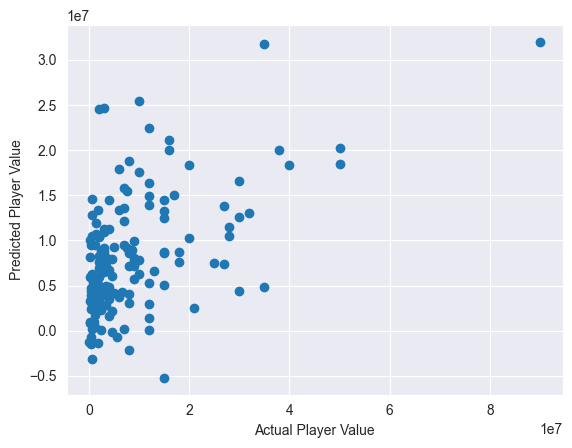

In [264]:
plt.scatter(y_test, midfield_predictions)
plt.xlabel('Actual Player Value')
plt.ylabel('Predicted Player Value')

#### Visualizing the Residuals

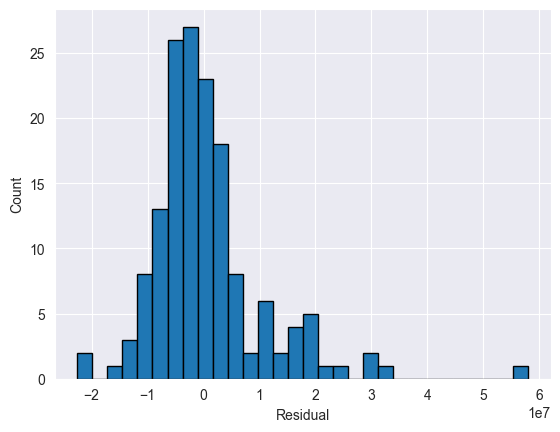

In [265]:
plt.hist(y_test - midfield_predictions, edgecolor='black', bins=30)  # increase the bins to 20
plt.ylabel("Count")
plt.xlabel("Residual")
plt.show()


#### Mean Absolute Error

In [266]:
metrics.mean_absolute_error(y_test, midfield_predictions)

6878263.493821438

#### Mean Squared Error

In [267]:
metrics.mean_squared_error(y_test, midfield_predictions)

104823081088205.44

#### Root-Mean Square

In [268]:
np.sqrt(metrics.mean_squared_error(y_test, midfield_predictions))

10238314.367521904

In [269]:
X = defenders[defender_features]
y = defenders['price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
lreg = LinearRegression()
lreg.fit(X_train, y_train)
defender_coefficients = pd.DataFrame(lreg.coef_, defender_features, columns = ['Coeff']).sort_values(by='Coeff', ascending=False)
defender_predictions = lreg.predict(X_test)

Text(0, 0.5, 'Predicted Player Value')

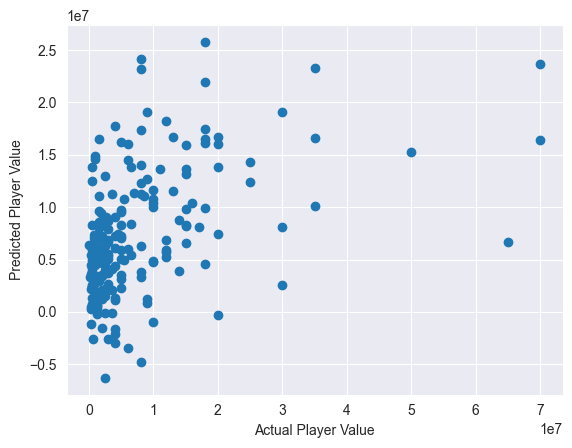

In [270]:
plt.scatter(y_test, defender_predictions)
plt.xlabel('Actual Player Value')
plt.ylabel('Predicted Player Value')

#### Visualizing the Residuals

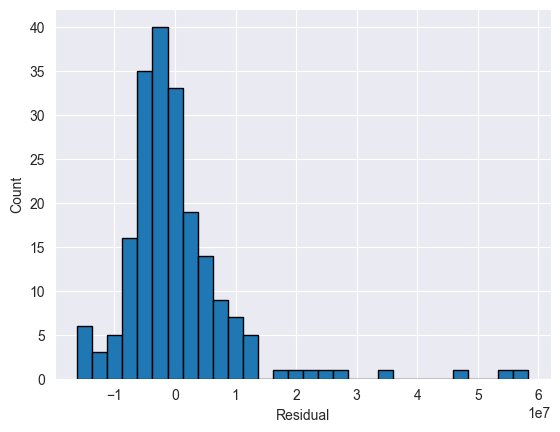

In [271]:
plt.hist(y_test - defender_predictions, edgecolor='black', bins=30)  # increase the bins to 20
plt.ylabel("Count")
plt.xlabel("Residual")
plt.show()


#### Mean Absolute Error

In [272]:
metrics.mean_absolute_error(y_test, defender_predictions)

5923740.667932961

#### Mean Squared Error

In [273]:
metrics.mean_squared_error(y_test, defender_predictions)

93703360489535.69

#### Root-Mean Square

In [274]:
np.sqrt(metrics.mean_squared_error(y_test, defender_predictions))

9680049.611935658

### Comparisons of the Linear Regression Iterations

In [ ]:
| Iteration | Mean Absolute Error | Mean Squared Error | Root-Mean Square |
| --------------- | --------------- | --------------- | --------------- |
| Initial Dataset  | 7929914 | 159388405721906 | 12624912.107492315 |
| Removal of Outliers  | 6113963.07  | 89341122728980.95  | 9452043.31 |
| By Position (Attackers)  | 6012912.28 | 76724556854556.86  | 8759255.50 |
| By Position (Midfielders) | 7450062.11 | 144403878111358.78 | 12016816.47 |
| By Position (Defenders) | 7450062.11 | 144403878111358.78 | 12016816.47 |

## Conclusion <a class="anchor" id="conclusion"></a>

In [ ]:
#### Clustering Algorithm

## Limitations and Next Steps <a class="anchor" id="next-steps"></a>

As previously stated, this project used web scraping of player data from seven of the most popular and successful soccer leagues in Europe. Before cleaning the data and removing outliers, this dataset contained approximately 2500 players. While this amount was certainly enough for the scope of this project, the model could be made more accurate by obtaining data from more players both in Europe and abroad. Given more time and resources to access player data, a future objective would have a dataset that encompasses nearly all of the 130 000 players registered in FIFA’s system. 

Another limitation of this project revolves around positions. For the sake of time and simplicity, a player’s position was assimilated and changed to a general position. For example, any players that were originally classified as Left Midfielders, Center Midfielders, Right Midfielders, Attacking Midfielders or  Defensive Midfielders were changed simply to Midfielder. The same idea was applied to all the different types of attacking and defending positions. Again, with additional time resources, the model could be further improved to predict the value of a specific type of midfield player instead of midfielders in general. 

As stated above, with the bigger dataset the position of goalkeeping is another step that could be incorporated into future versions. As mentioned in the project scope, due to the inherent small number of goalkeepers on a team compared to other positions, the dataset would have been too small to generate meaningful results. Furthermore, unlike outfield positions which can be compared with a similar set of statistics, goalkeepers have completely different metrics to calculate their value. 

Furthermore, our model assumed that the teams and leagues are all equal. However, this is not the case. For example, the English Premier League is widely considered to the greatest in the world and can contain the best players. In contrast, while the Portuguese League is formidable, it is not at the same level as the top leagues in Europe. This creates issues as a player in an inferior league may have stronger stats than someone playing against much tougher competition in countries such as England or Spain. As a result, the lower league player may be determined to be more valuable when in reality that is not the case. One way to address this issue is to tag each player by the league they are in and use that to create fair comparisons between player stats in different leagues. 

In soccer, most teams have around 20 players, but only the starting 11 play consistently. As a result, only half of our nearly 2800 player dataset play regularly. This may lead to skewness in statistics (right-skewness and general bias). Furthermore, some players at top teams may have high value but are on the bench for most games due to the depth of the team. As a result, their stats are quite poor when compared against their market value. One example is winger Jadon Sancho of Manchester United. Valued at around 130 million euros a few seasons ago as a teenager, he was acquired with the hopes of solidifying one of the winger roles for seasons to come. Unfortunately, due to the emergence of other players combined with his lackluster production, Sancho is often on the bench. His high value but poor stats are one example of an outlier that could affect the performance of this model. A next step would be to adjust player stats to a rate based on the number of minutes or matches played. 

The final limitation is the presence of non-quantitative factors that affect a player’s value. Above all, a soccer club is a business with the goal of making money through merchandise, licensing, tickets and media broadcasting deals. In order to be profitable, a team needs to have marketable assets, more specifically marketable players. A part of a player's value is tied to how much money and interest they can generate for the team they play for. This is especially true for superstars whose presence at the club can lead to sky rocketing jerseys and ticket sales. This factor was not incorporated into the features of this model as it is difficult to quantify a player's marketability and find reliable data, especially for players part of smaller teams or leagues. 
